In [2]:
%load_ext autoreload

In [3]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

from utils.min_norm_solvers_numpy import MinNormSolverNumpy, gradient_normalizers

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
%autoreload

In [6]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [7]:
data_dir = os.path.join('data', '1.2')

# Environment Setup

In [8]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

# tile_map = [
#         "2FFFUFFF1",
#         "FFFU3UFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUUSUUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFUUUFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':8.0,
              'S':0.0,
              'U':0.0}


# Enables "texturizing" the environment such that certain areas
# will have greater reward despite being the same tile types
tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

true_tps = np.array([[[0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 0.999]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.0, 0.999]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [9]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

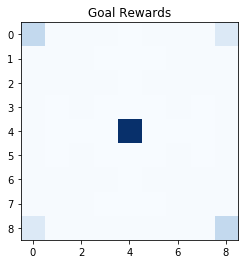

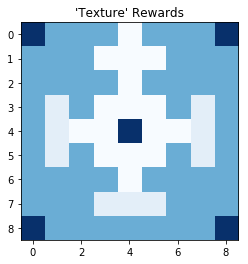

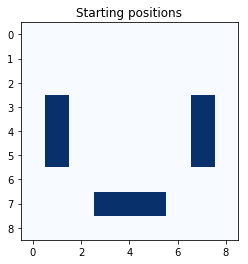

In [10]:
plt.imshow(reward_map, cmap="Blues")
plt.title("Goal Rewards")
plt.show()
plt.imshow(texture_map, cmap="Blues")
plt.title("'Texture' Rewards")
plt.show()

binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")
plt.title("Starting positions")
plt.show()

# Demo visualization tools

In [11]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning for Demonstrations

In [12]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [13]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = logsumexp(prevQ, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [14]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [15]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [16]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


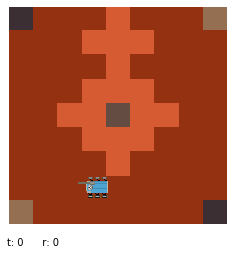

[42.51647045 41.68794848 39.33647824 39.37253894 40.91782063]
0
[0.58019364 0.25336723 0.02412792 0.02501387 0.11729734]
(3, 7) b'S'
(2, 7) b'F'


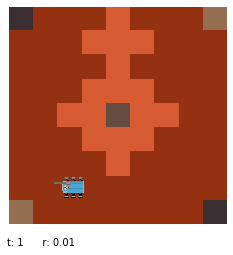

[44.67009291 44.13379464 41.34869765 41.7392116  43.08604636]
0
[0.53205494 0.31120395 0.01920847 0.02838513 0.1091475 ]
(2, 7) b'F'
(1, 7) b'F'


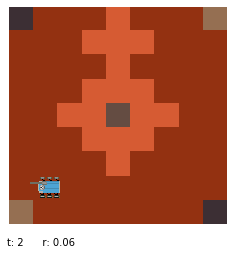

[46.59219686 46.5898783  43.47672709 43.48652773 45.1095647 ]
0
[0.43217535 0.43117448 0.01917029 0.01935909 0.09812079]
(1, 7) b'F'
(0, 7) b'F'


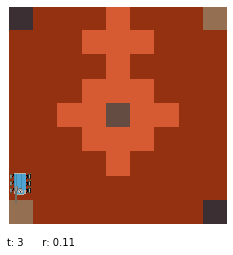

[47.4580397  49.0954187  45.50952216 44.81049975 46.98038357]
1
[0.14336463 0.73713439 0.02042733 0.01015383 0.08891982]
(0, 7) b'F'
(0, 8) b'1'


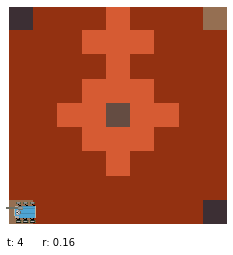

[51.36456163 51.36399322 48.39972108 48.40072075 50.83742633]
0
[0.37134491 0.37113389 0.01914977 0.01916892 0.21920251]
(0, 8) b'1'
(8, 8) b'2'


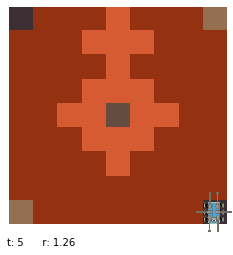

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


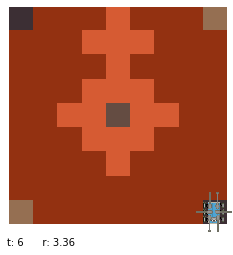

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


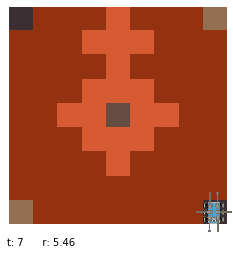

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


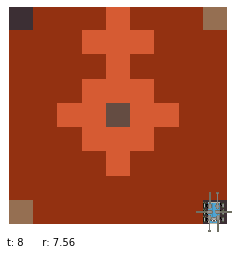

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


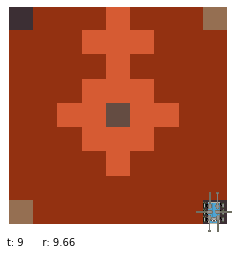

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


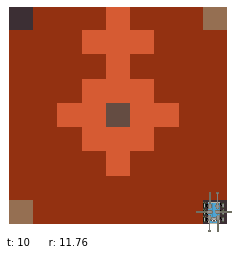

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


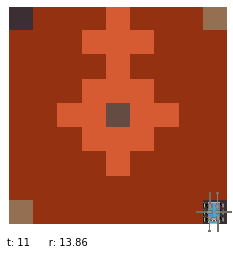

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


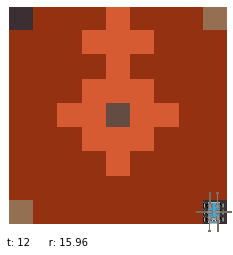

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


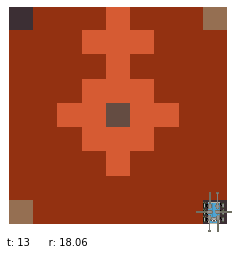

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


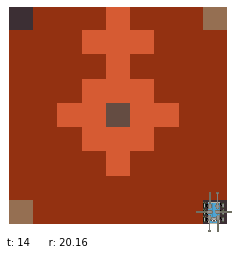

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


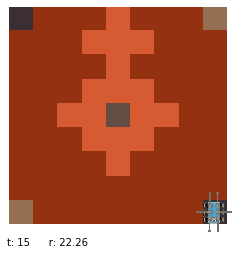

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


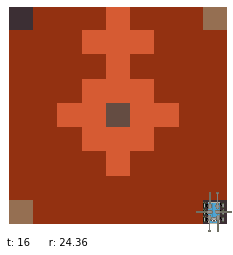

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


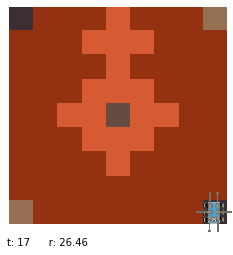

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


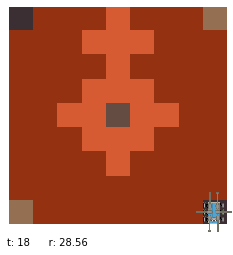

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


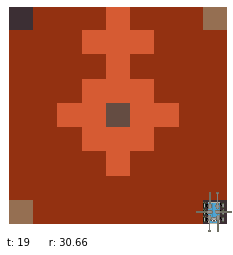

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


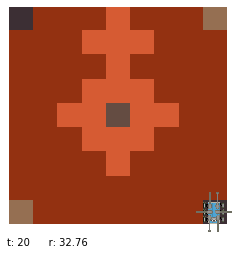

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


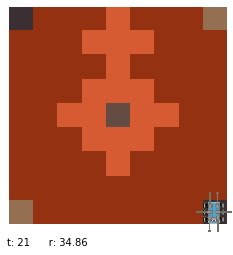

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


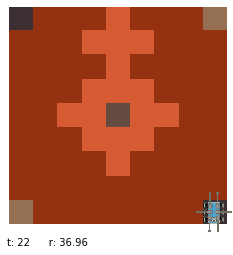

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


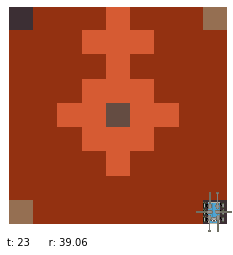

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


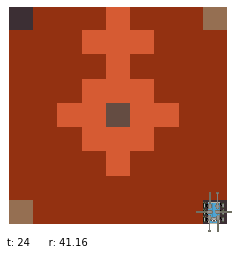

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


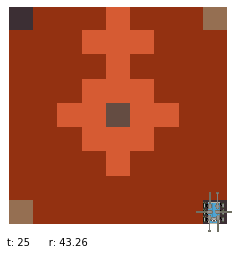

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


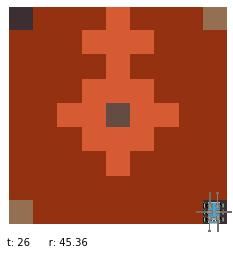

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


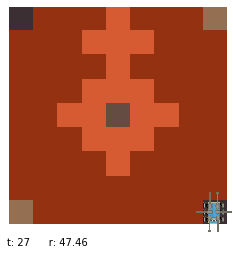

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


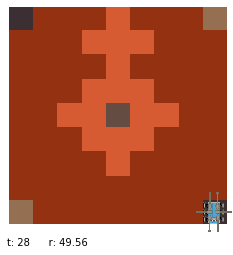

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


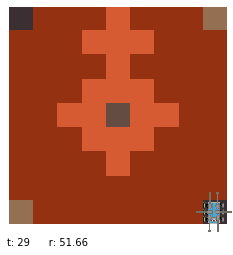

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


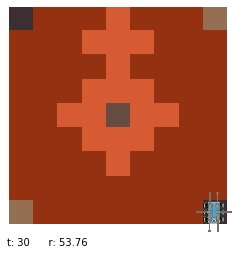

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


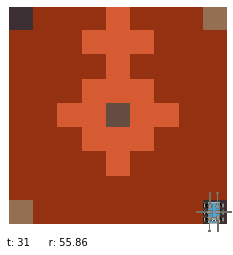

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


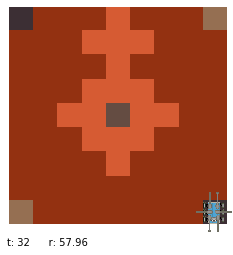

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


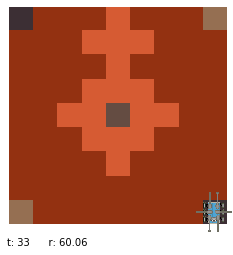

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


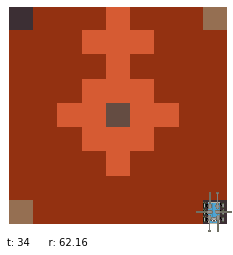

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


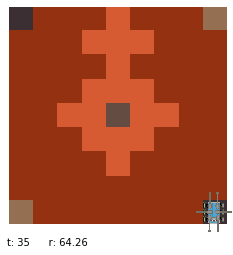

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


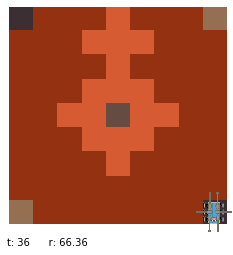

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


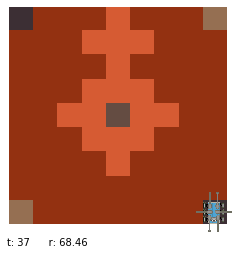

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


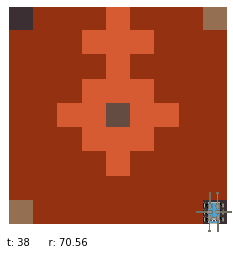

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


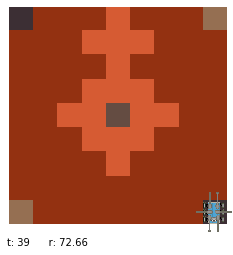

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


In [17]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# Model Set Up

In [18]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
batch_size = 512
sq_td_err_penalty = 1
trans_penalty = 1
t_err_penalty = 2e-1
q_err_penalty = 1e0


q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [19]:
n_obs_feats = 2
n_act_dim = 5
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 5

In [20]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [21]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)

    return feat_states, acts_array, rewards, sprimes, tiles

In [22]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######

# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [23]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [24]:
sess = tf.Session()

In [25]:
# Demo placeholders are for the action-likelihood and transition-likelihood portions of the loss
# Constraint placeholders are for the bellman-residual penalty

demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [26]:
# Boltz-beta determines the "rationality" of the agent being modeled. 
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

In [27]:
action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [28]:
# Encoded the potential to use "sas" transitions, which are simply state, action, state observations,
# and "adt" transitions -- post-processed to determine (a)ction taken, (d)irection moved, and starting (t)ile-type
# Learning an "adt" transition model should be much easier

sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [29]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [30]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [31]:
# Q-values used to calculate 'V' in the bellman-residual
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_logsumexp(constraint_q_tp1, axis=2) 

In [32]:
# sas bellman residual penalty error
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)


# adt bellman residual penalty error
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [33]:
# sas and adt bellman residual penalty error with a stop gradient on transitions to prevent the bellman update from
# 'hacking' the transition function to overly explain the demonstrations. This happens a lot early on before the
# Q-values have obtained much meaning

sas_V_sgt = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
sas_target_sgt = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sgt, axis=1)
sas_td_err_sgt = tf.reduce_mean((constraint_q_t - sas_target_sgt)**2)

adt_V_sgt = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
adt_target_sgt = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sgt, axis=1)
adt_td_err_sgt = tf.reduce_mean((constraint_q_t - adt_target_sgt)**2)


# sas and adt bellman residual penalty error with a stop gradient on q-fn to allow the bellman residual loss to update
# differences in learned q-vals w.r.t. the dynamics model

adt_V_sgq = tf.multiply(tf.stop_gradient(constraint_v_tp1), constraint_adt_pred_probs)
adt_target_sgq = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sgq, axis=1)
adt_td_err_sgq = tf.reduce_mean((tf.stop_gradient(constraint_q_t) - adt_target_sgq)**2)

In [34]:
# Total loss function for the sas formulation
sas_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err

# Total loss function for the adt formulation
adt_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err

# Loss function for the adt formulation that only optimizes over the q-value approximation 
adt_q_loss = neg_avg_act_log_likelihood + q_err_penalty * adt_td_err_sgt

# Loss function for the adt formulation that only optimizes over the dynamics model
adt_t_loss = neg_avg_adt_log_likelihood + t_err_penalty * adt_td_err_sgq

# Loss function for the adt formulation that learns unseen dynamics (include adt_ll to prevent abuse of confident transitions)
adt_learn_loss = neg_avg_act_log_likelihood + neg_avg_adt_log_likelihood + t_err_penalty * adt_td_err_sgq

# Loss function for the adt formulation that regularizes over observed and learned quantities
adt_regularize_loss = neg_avg_adt_log_likelihood + q_err_penalty * adt_td_err_sgt

# Total loss function for the adt formulation with a stop-gradient on the transition function for the bellman residual
adt_brsgt_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err_sgt

In [35]:
sas_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(sas_loss)

adt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_loss)

adt_brsgt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_brsgt_loss)

adt_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_q_loss)

adt_t_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_t_loss)

adt_learn_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_learn_loss)

adt_regularize_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_regularize_loss)

adt_trans_only_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_adt_log_likelihood)

adt_q_br_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_td_err_sgt)

q_nll_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_act_log_likelihood)

In [36]:
# Uncertainty weighted loss function motivated by https://arxiv.org/pdf/1705.07115.pdf

sigma_a, sigma_t, sigma_br = tf.Variable(0.0), tf.Variable(0.0), tf.Variable(0.0)

# Simple sum is sufficient so long as all losses use means
sigma_log_losses = sigma_a + sigma_t # + sigma_br

weighted_na_act_ll = tf.exp(-sigma_a) * neg_avg_act_log_likelihood

weighted_na_adt_ll = tf.exp(-sigma_t) * neg_avg_adt_log_likelihood

weighted_na_br = (adt_td_err * sq_td_err_penalty + adt_td_err_sgt * 3 * sq_td_err_penalty) / 4 #tf.exp(-sigma_br) * 

adt_uncertainty_loss = weighted_na_act_ll + weighted_na_adt_ll + weighted_na_br + sigma_log_losses

adt_un_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_uncertainty_loss)

In [37]:
# Add in ability to train the q-fn approximator on the true values to test model capacity
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(true_q_err)

In [38]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    # Naive case of only optimizing over observed transitions -- useful to initialize the dynamics model
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    # Optimization over the full adt loss function
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # Optimization over the adt uncertainty-weighted loss function
    if update == "adt_un":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval, sig_a, sig_t, sig_br] = sess.run(
            [adt_uncertainty_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood,
                 sigma_a, sigma_t, sigma_br], feed_dict=feed_dict)
        update_op = adt_un_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval,
            'sigmas': (sig_a, sig_t, sig_br)}
        
    # Optimizing only the q-fn over the bellman residual, equivalent to soft Q-learning
    if update == "adt_br":
        [loss_eval] = sess.run([adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
    
    # Optimization over the full adt loss function with a stop gradient on the dynamics model for the bellman residual
    # Useful in getting the q-fn to match both the observed dynamics and the observed actions taken
    if update == "adt_brsgt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err_sgt, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_brsgt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the action likelihood and br with a stop gradient on the dynamics model for the br
    if update == "adt_q":
        [loss_eval, act_likelihood_eval, td_err_eval] = sess.run(
            [adt_q_loss, neg_avg_act_log_likelihood, adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_q_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval}
        
    # Optimization over the action likelihood and br with a stop gradient on the q-fn for the br
    if update == "adt_learn":
        [loss_eval,  trans_likelihood_eval, td_err_eval, act_likelihood_eval] = sess.run(
            [adt_learn_loss, neg_avg_adt_log_likelihood, adt_td_err_sgq, neg_avg_act_log_likelihood], feed_dict=feed_dict)
        update_op = adt_learn_update_op
        d = {'loss': loss_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval,
            'nall': act_likelihood_eval}
        
    # Optimization over the transition likelihood and br with a stop gradient on the dynamics for the br
    if update == "adt_regularize":
        [loss_eval, trans_likelihood_eval, td_err_eval] = sess.run(
            [adt_regularize_loss, neg_avg_adt_log_likelihood, adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_regularize_update_op
        d = {'loss': loss_eval,
            'ntll': trans_likelihood_eval,
            'tde': td_err_eval}
        
    # Optimization over the transition likelihood and br with a stop gradient on the q-fn for the br
    if update == "adt_t":
        [loss_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_t_loss, adt_td_err_sgq, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_t_update_op
        d = {'loss': loss_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the full sas loss function
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # For debugging and testing model capacity
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)

    return d

In [39]:
def update_switcher(update, update_progression, losses, slope_threshold=1e-4, horizon=100):
    
    if len(losses) <= 3:
        switch = False
    else:
        if len(losses) < horizon:
            horizon = len(losses)
        slope = np.polyfit(np.arange(horizon), losses[-horizon:], 1)[0]
        switch = -slope < slope_threshold
        
        print(-slope, switch)
        
    if switch:
        if update not in update_progression:
            update = update_progression[0]
        else:
            update = update_progression[(update_progression.index(update) + 1) % len(update_progression)]
        
    return update

# IDL Experiments

## Demo setup

In [40]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [41]:
def clean_demos(sas_obs, max_noops=15):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [42]:
exQs = tabsoftq_learn_Qs(mdp)
# The rationality constant used to generate demos could certainly vary from the one used in the model.....
temp_boltz_beta = 50
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * temp_boltz_beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [43]:
# Ensure bad areas have not been visited in exes (this is unique to this experiment)
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if len(set([adt[2] for adt in more_adt])) == 1:
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

In [44]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [45]:
# True q-vals for debugging and comparison purposes
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# Preprocessing for training update visualizations
tts = np.arange(2)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]
states = featurize_states(np.arange(mdp.nS))

# Optional preloading of q-fn or dynamics models
# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

# invadt_path = os.path.join(data_dir, 'adt_t.tf')
# load_tf_vars(sess, invadt_scope, invadt_path)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


## IDL Training

In [46]:
n_training_iters = 1000000

In [47]:
tf.global_variables_initializer().run(session=sess)

In [48]:
train_log_base = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
  'sigmas_evals': []
}

mode_logs = {}

val_log = None

In [49]:
# The best order of optimization seems to be "trans" -> "adt_br" -> "adt_brsgt" -> "adt" [->"adt-br"->"adt"]

# update = "trans"
# update = "adt_q"
# update = "adt_t"

# update = "adt_learn"
# update = "trans"
# update = "adt_br"
# update = "adt_regularize"

update_progression = ["adt_br", "adt_learn"]

for up in update_progression:
    mode_logs[up] = copy(train_log_base)
    
update = "trans"
mode_logs[update] = copy(train_log_base)

full_train_logs = mode_logs[update]


# update = "adt_br"
# update = "adt_brsgt"
# update = "adt"
# update = "adt_un"

In [50]:
total_train_time, i = 0, 0

[('loss', 1.8803492)]


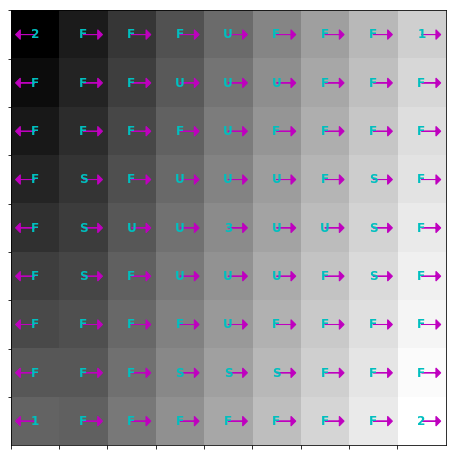

[[0.19992848 0.19999012 0.19995306 0.19992948 0.20019883]
 [0.20827588 0.20919238 0.188442   0.21153691 0.18255284]
 [0.21627127 0.21799439 0.17694041 0.22308472 0.16570917]
 [0.22377613 0.22636011 0.16555084 0.2344275  0.14988549]
 [0.23075628 0.23424977 0.15436918 0.24551168 0.1351131 ]
 [0.20247617 0.19658692 0.19640073 0.20520514 0.19933097]
 [0.2062827  0.22671747 0.17672923 0.20528343 0.18498714]
 [0.21453632 0.24480973 0.16584888 0.20981485 0.16499023]
 [0.22177139 0.25820172 0.154729   0.21666904 0.1486289 ]
 [0.2289826  0.26723385 0.14468035 0.22390641 0.13519675]]


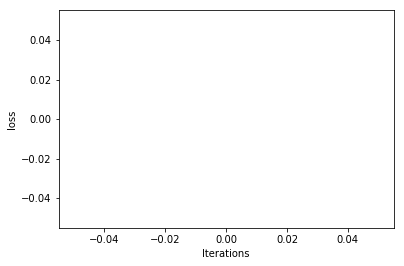

0.008164410739958232 False
[('loss', 0.6368096)]
0.003948405174174688 False
[('loss', 0.51981807)]
0.0022586983093584485 False
[('loss', 0.41251686)]
0.0019012250713925788 False
[('loss', 0.33074474)]
0.0013602123538045039 False
[('loss', 0.2753131)]


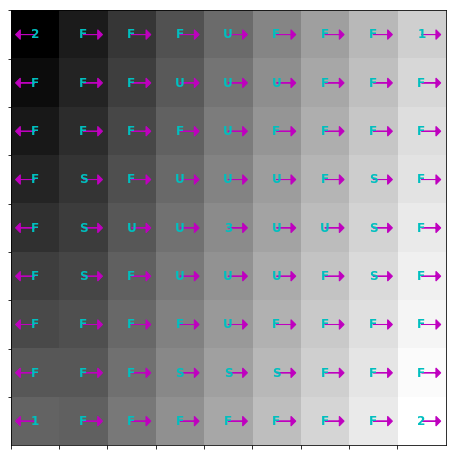

[[0.6009381  0.28254858 0.06716114 0.0468814  0.00247083]
 [0.13102216 0.7093242  0.11926383 0.03945943 0.00093039]
 [0.06416328 0.15730365 0.5904811  0.18163595 0.00641598]
 [0.04363598 0.01385898 0.18290177 0.39408225 0.3655211 ]
 [0.00114577 0.00004459 0.00194671 0.027889   0.96897393]
 [0.570853   0.30153587 0.07790738 0.04721415 0.0024895 ]
 [0.1916413  0.62198347 0.1380367  0.04700657 0.00133196]
 [0.11180336 0.24005286 0.44707435 0.19041698 0.01065245]
 [0.05860799 0.02013019 0.17054486 0.3634448  0.38727218]
 [0.00164247 0.00007315 0.00207747 0.0303264  0.96588045]]


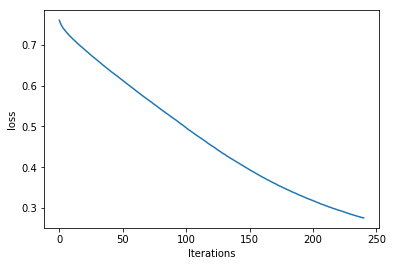

0.0008763608010080607 False
[('loss', 0.24203156)]
0.0005086973228148444 False
[('loss', 0.22295599)]
0.0002848482814201401 False
[('loss', 0.21274209)]
0.00015799943289526605 False
[('loss', 0.2067515)]
9.086038144973125e-05 True
========= Switching to adt_br =========


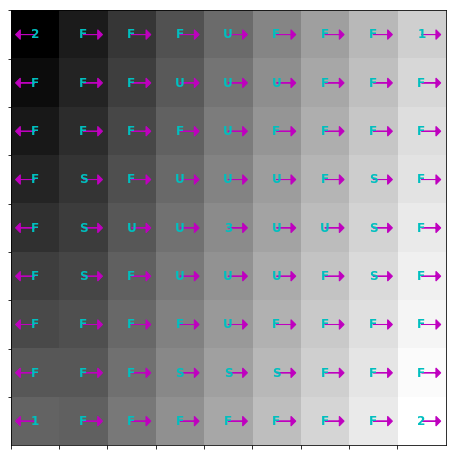

[[0.82123196 0.12883303 0.02227821 0.02763625 0.00002056]
 [0.0850256  0.8066256  0.08852082 0.0198247  0.00000317]
 [0.01640525 0.11295117 0.7837158  0.08691236 0.00001544]
 [0.07959323 0.01221687 0.13288279 0.70473844 0.07056873]
 [0.00064075 0.00000203 0.00002832 0.00456903 0.99475986]
 [0.8005309  0.14388615 0.02754808 0.02801439 0.00002054]
 [0.13676885 0.73753756 0.10131818 0.02437089 0.00000445]
 [0.04508054 0.22039163 0.6155999  0.11888666 0.0000413 ]
 [0.1207143  0.01832166 0.11933214 0.66111284 0.08051903]
 [0.00108862 0.0000036  0.00003101 0.00634176 0.992535  ]]
0.03420905351352577 False
[('loss', 2.3124537)]
0.046666375028096334 False
[('loss', 0.6593603)]
0.013189163805484906 False
[('loss', 0.45794374)]
0.002932219333452681 False
[('loss', 0.34623194)]
0.0016209880984870309 False
[('loss', 0.28953886)]


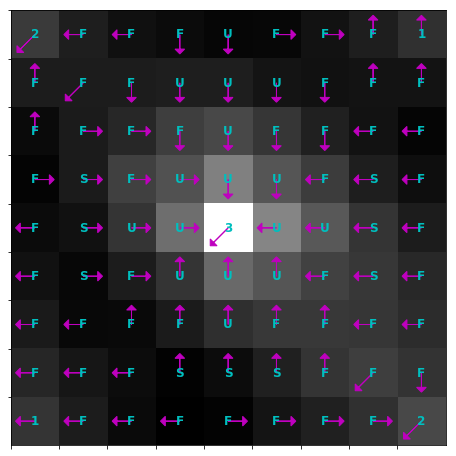

[[0.82123196 0.12883303 0.02227821 0.02763625 0.00002056]
 [0.0850256  0.8066256  0.08852082 0.0198247  0.00000317]
 [0.01640525 0.11295117 0.7837158  0.08691236 0.00001544]
 [0.07959323 0.01221687 0.13288279 0.70473844 0.07056873]
 [0.00064075 0.00000203 0.00002832 0.00456903 0.99475986]
 [0.8005309  0.14388615 0.02754808 0.02801439 0.00002054]
 [0.13676885 0.73753756 0.10131818 0.02437089 0.00000445]
 [0.04508054 0.22039163 0.6155999  0.11888666 0.0000413 ]
 [0.1207143  0.01832166 0.11933214 0.66111284 0.08051903]
 [0.00108862 0.0000036  0.00003101 0.00634176 0.992535  ]]


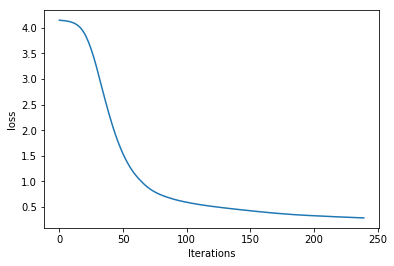

0.0009916246648203908 False
[('loss', 0.24424067)]
0.0008386692202667055 False
[('loss', 0.20673591)]
0.0006675333254086244 False
[('loss', 0.17653188)]
0.0005380021989291904 False
[('loss', 0.15365025)]
0.0003997628016583463 False
[('loss', 0.1363013)]


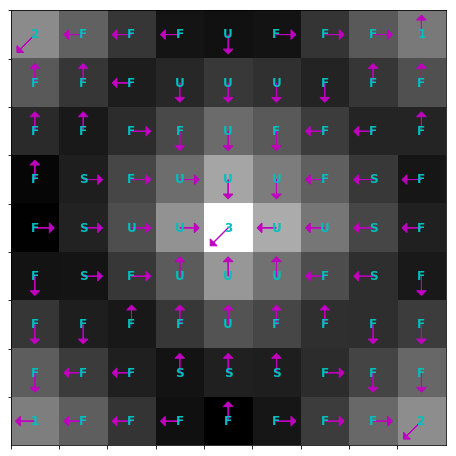

[[0.82123196 0.12883303 0.02227821 0.02763625 0.00002056]
 [0.0850256  0.8066256  0.08852082 0.0198247  0.00000317]
 [0.01640525 0.11295117 0.7837158  0.08691236 0.00001544]
 [0.07959323 0.01221687 0.13288279 0.70473844 0.07056873]
 [0.00064075 0.00000203 0.00002832 0.00456903 0.99475986]
 [0.8005309  0.14388615 0.02754808 0.02801439 0.00002054]
 [0.13676885 0.73753756 0.10131818 0.02437089 0.00000445]
 [0.04508054 0.22039163 0.6155999  0.11888666 0.0000413 ]
 [0.1207143  0.01832166 0.11933214 0.66111284 0.08051903]
 [0.00108862 0.0000036  0.00003101 0.00634176 0.992535  ]]


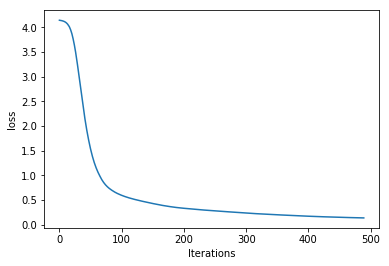

0.0002877140937089713 False
[('loss', 0.12402145)]
0.00021290559950906354 False
[('loss', 0.114888944)]
0.00016213660921701378 False
[('loss', 0.10770225)]
0.00012851150649966628 False
[('loss', 0.10209264)]
0.000105532510141836 False
[('loss', 0.09702231)]


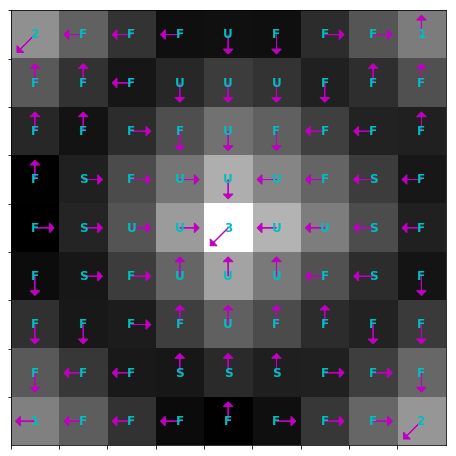

[[0.82123196 0.12883303 0.02227821 0.02763625 0.00002056]
 [0.0850256  0.8066256  0.08852082 0.0198247  0.00000317]
 [0.01640525 0.11295117 0.7837158  0.08691236 0.00001544]
 [0.07959323 0.01221687 0.13288279 0.70473844 0.07056873]
 [0.00064075 0.00000203 0.00002832 0.00456903 0.99475986]
 [0.8005309  0.14388615 0.02754808 0.02801439 0.00002054]
 [0.13676885 0.73753756 0.10131818 0.02437089 0.00000445]
 [0.04508054 0.22039163 0.6155999  0.11888666 0.0000413 ]
 [0.1207143  0.01832166 0.11933214 0.66111284 0.08051903]
 [0.00108862 0.0000036  0.00003101 0.00634176 0.992535  ]]


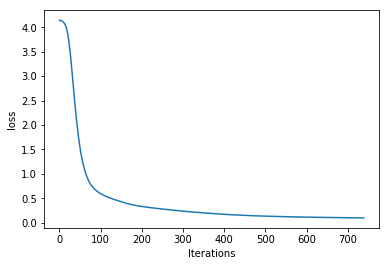

8.906096152954571e-05 True
========= Switching to adt_learn =========


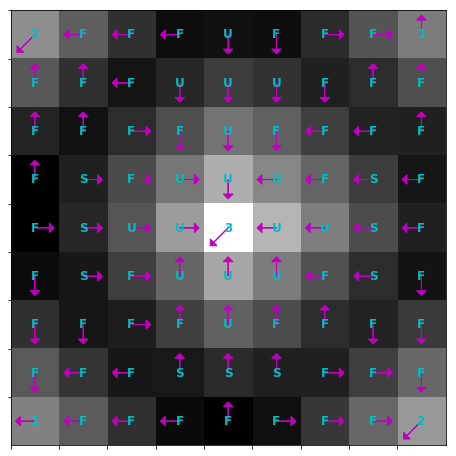

[[0.82123196 0.12883303 0.02227821 0.02763625 0.00002056]
 [0.0850256  0.8066256  0.08852082 0.0198247  0.00000317]
 [0.01640525 0.11295117 0.7837158  0.08691236 0.00001544]
 [0.07959323 0.01221687 0.13288279 0.70473844 0.07056873]
 [0.00064075 0.00000203 0.00002832 0.00456903 0.99475986]
 [0.8005309  0.14388615 0.02754808 0.02801439 0.00002054]
 [0.13676885 0.73753756 0.10131818 0.02437089 0.00000445]
 [0.04508054 0.22039163 0.6155999  0.11888666 0.0000413 ]
 [0.1207143  0.01832166 0.11933214 0.66111284 0.08051903]
 [0.00108862 0.0000036  0.00003101 0.00634176 0.992535  ]]
0.01341182551034792 False
[('nall', 0.22077386), ('loss', 0.71362126), ('ntll', 0.20716682), ('tde', 1.4284029)]
0.004071036506764996 False
[('nall', 0.13919894), ('loss', 0.6390636), ('ntll', 0.20440885), ('tde', 1.477279)]
-3.823418929131336e-05 True
========= Switching to adt_br =========


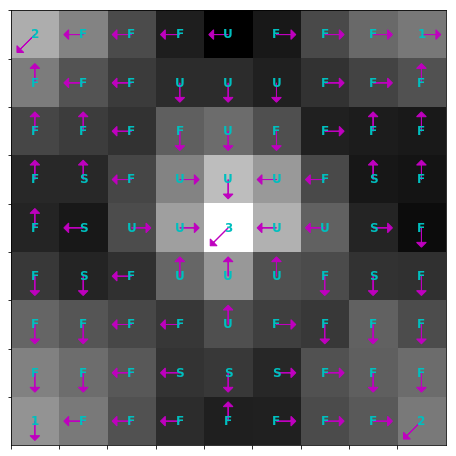

[[0.6893442  0.18846495 0.0373532  0.08480731 0.0000303 ]
 [0.10526254 0.7848746  0.08908176 0.02078021 0.00000093]
 [0.03303949 0.15936336 0.7277434  0.07984989 0.00000381]
 [0.1374677  0.00803378 0.14633408 0.6725084  0.03565601]
 [0.00030933 0.0000002  0.00000942 0.00122436 0.9984567 ]
 [0.47504583 0.24048652 0.18471317 0.09790667 0.00184779]
 [0.18977018 0.5343146  0.18252279 0.09333035 0.00006212]
 [0.1534853  0.23289782 0.42439726 0.18837345 0.00084622]
 [0.05896994 0.00490031 0.08266788 0.32552403 0.5279379 ]
 [0.00001305 0.00000001 0.00000053 0.00006884 0.9999175 ]]


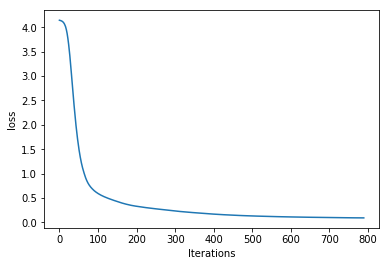

0.0016426041944115702 False
[('loss', 0.07387608)]
0.0005935169126477432 False
[('loss', 0.0688633)]
5.354848645343623e-05 True
========= Switching to adt_learn =========


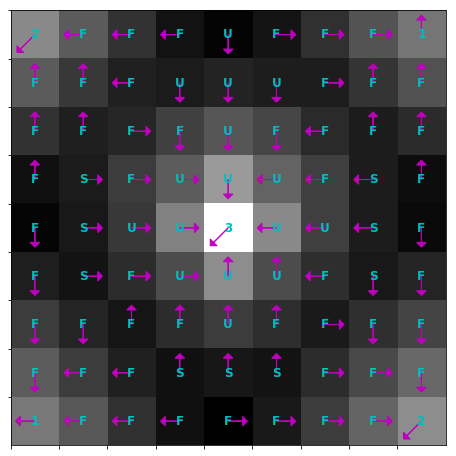

[[0.6893442  0.18846495 0.0373532  0.08480731 0.0000303 ]
 [0.10526254 0.7848746  0.08908176 0.02078021 0.00000093]
 [0.03303949 0.15936336 0.7277434  0.07984989 0.00000381]
 [0.1374677  0.00803378 0.14633408 0.6725084  0.03565601]
 [0.00030933 0.0000002  0.00000942 0.00122436 0.9984567 ]
 [0.47504583 0.24048652 0.18471317 0.09790667 0.00184779]
 [0.18977018 0.5343146  0.18252279 0.09333035 0.00006212]
 [0.1534853  0.23289782 0.42439726 0.18837345 0.00084622]
 [0.05896994 0.00490031 0.08266788 0.32552403 0.5279379 ]
 [0.00001305 0.00000001 0.00000053 0.00006884 0.9999175 ]]


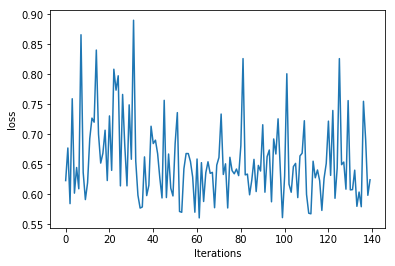

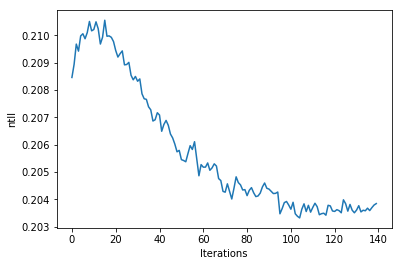

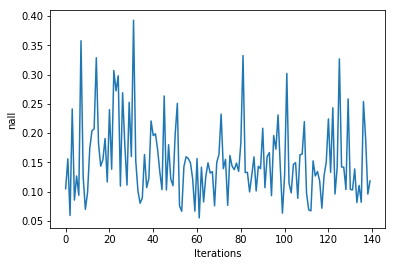

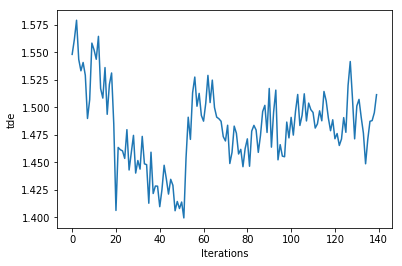

0.0018439809357275675 False
[('nall', 0.09048719), ('loss', 0.62033665), ('ntll', 0.20399342), ('tde', 1.6292803)]
0.0006253659388985376 False
[('nall', 0.23386618), ('loss', 0.76326597), ('ntll', 0.20321399), ('tde', 1.6309291)]
-0.0002172314730843646 True
========= Switching to adt_br =========


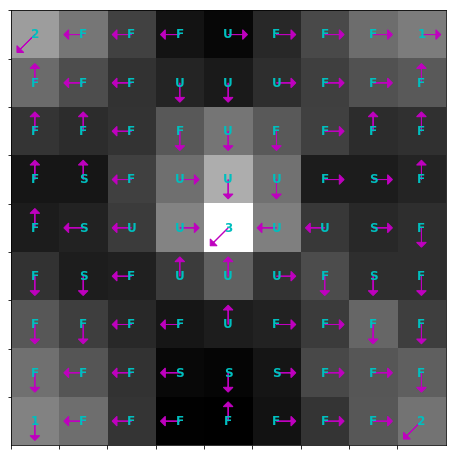

[[0.6387752  0.22124545 0.02692797 0.11295477 0.00009659]
 [0.10076288 0.80266327 0.08173157 0.01484197 0.00000029]
 [0.02889674 0.13931447 0.7702941  0.06149372 0.00000104]
 [0.14558847 0.00306715 0.17565912 0.65405494 0.02163024]
 [0.00016072 0.00000001 0.00000607 0.00058915 0.9992441 ]
 [0.29512092 0.09593365 0.12880161 0.01435861 0.46578515]
 [0.19726092 0.47990757 0.22757834 0.09466824 0.0005849 ]
 [0.23121694 0.2570796  0.39011452 0.12093717 0.00065179]
 [0.09748986 0.00427901 0.10836556 0.23360832 0.55625725]
 [0.00000597 0.         0.00000021 0.00001326 0.99998057]]


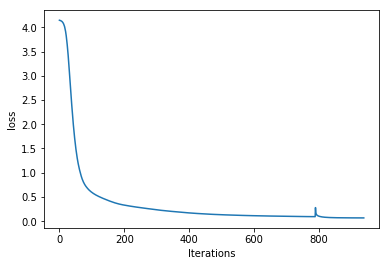

0.000957260898181373 False
[('loss', 0.07088123)]
0.00032309534807767483 False
[('loss', 0.06816842)]
3.225692521871276e-05 True
========= Switching to adt_learn =========


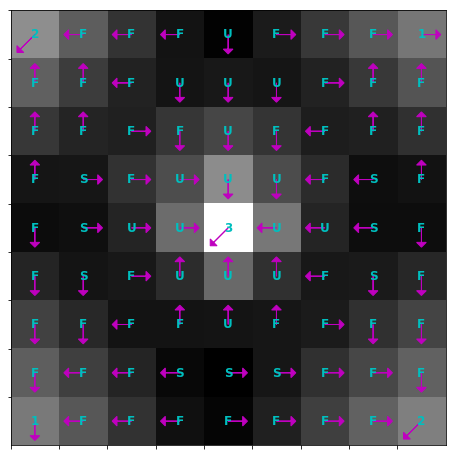

[[0.6387752  0.22124545 0.02692797 0.11295477 0.00009659]
 [0.10076288 0.80266327 0.08173157 0.01484197 0.00000029]
 [0.02889674 0.13931447 0.7702941  0.06149372 0.00000104]
 [0.14558847 0.00306715 0.17565912 0.65405494 0.02163024]
 [0.00016072 0.00000001 0.00000607 0.00058915 0.9992441 ]
 [0.29512092 0.09593365 0.12880161 0.01435861 0.46578515]
 [0.19726092 0.47990757 0.22757834 0.09466824 0.0005849 ]
 [0.23121694 0.2570796  0.39011452 0.12093717 0.00065179]
 [0.09748986 0.00427901 0.10836556 0.23360832 0.55625725]
 [0.00000597 0.         0.00000021 0.00001326 0.99998057]]


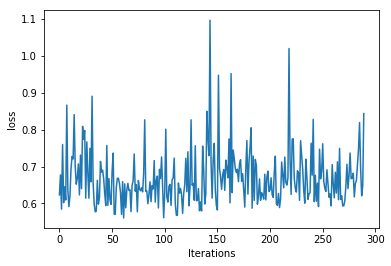

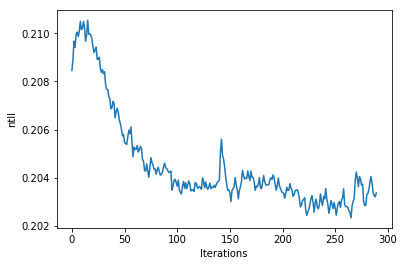

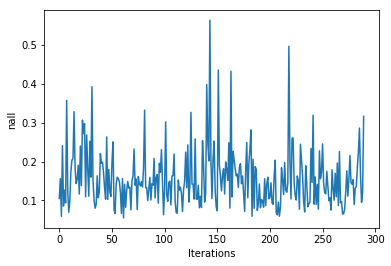

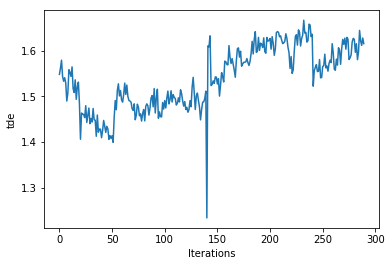

0.002497180631610107 False
[('nall', 0.19331375), ('loss', 0.63087714), ('ntll', 0.2026287), ('tde', 1.1746734)]
0.00050098514989658 False
[('nall', 0.19251515), ('loss', 0.6179712), ('ntll', 0.20272519), ('tde', 1.1136544)]
-0.0005316156469019489 True
========= Switching to adt_br =========


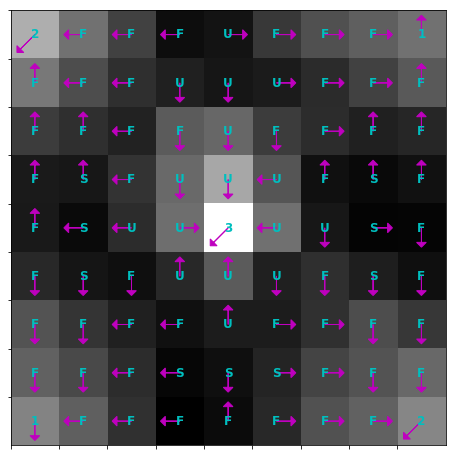

[[0.63542825 0.17325304 0.01644636 0.17481129 0.00006104]
 [0.08136708 0.8336383  0.0754511  0.00954343 0.00000006]
 [0.01998384 0.10812017 0.82157195 0.05032384 0.0000002 ]
 [0.12884867 0.00115991 0.14111595 0.71860003 0.01027533]
 [0.00009272 0.         0.00000311 0.00051686 0.99938726]
 [0.19370566 0.01876241 0.12134484 0.01665109 0.649536  ]
 [0.1696077  0.47182384 0.2649513  0.09322517 0.00039208]
 [0.23479192 0.28923628 0.38609493 0.08942468 0.00045221]
 [0.07633536 0.00307427 0.10704577 0.24066235 0.57288224]
 [0.00000128 0.         0.00000005 0.00000449 0.99999416]]


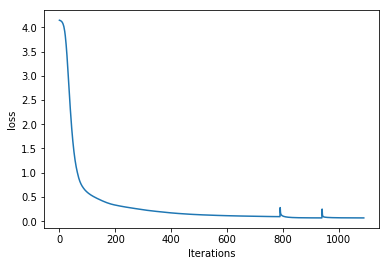

0.0005920284231599229 False
[('loss', 0.06971112)]
0.0001936378229175859 False
[('loss', 0.06799588)]
2.3920540914427058e-05 True
========= Switching to adt_learn =========


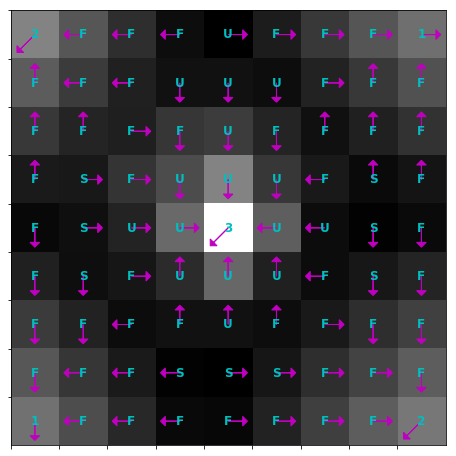

[[0.63542825 0.17325304 0.01644636 0.17481129 0.00006104]
 [0.08136708 0.8336383  0.0754511  0.00954343 0.00000006]
 [0.01998384 0.10812017 0.82157195 0.05032384 0.0000002 ]
 [0.12884867 0.00115991 0.14111595 0.71860003 0.01027533]
 [0.00009272 0.         0.00000311 0.00051686 0.99938726]
 [0.19370566 0.01876241 0.12134484 0.01665109 0.649536  ]
 [0.1696077  0.47182384 0.2649513  0.09322517 0.00039208]
 [0.23479192 0.28923628 0.38609493 0.08942468 0.00045221]
 [0.07633536 0.00307427 0.10704577 0.24066235 0.57288224]
 [0.00000128 0.         0.00000005 0.00000449 0.99999416]]


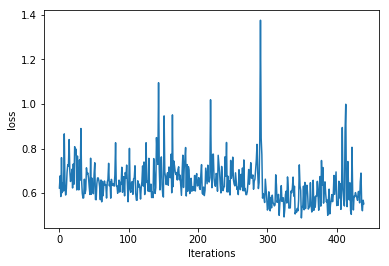

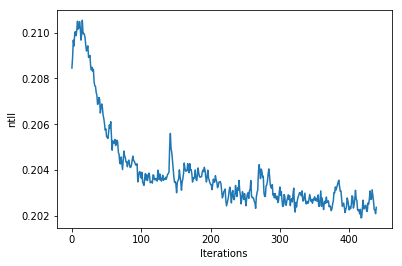

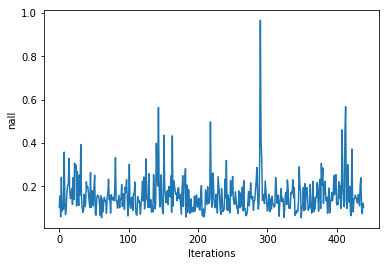

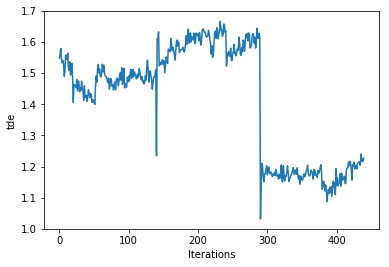

0.0007139685173996391 False
[('nall', 0.1256868), ('loss', 0.5513891), ('ntll', 0.20274471), ('tde', 1.1147879)]
0.00014192598326729185 False
[('nall', 0.20373878), ('loss', 0.6310169), ('ntll', 0.20242776), ('tde', 1.1242518)]
-0.0005981085451021946 True
========= Switching to adt_br =========


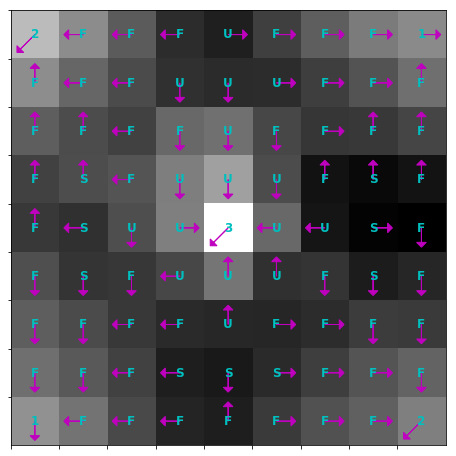

[[0.6138594  0.18063645 0.00943705 0.19602984 0.00003716]
 [0.10916753 0.7944561  0.08659725 0.00977918 0.00000004]
 [0.02220568 0.09604055 0.82846    0.05329363 0.00000013]
 [0.11754748 0.00089297 0.18720254 0.6849106  0.00944645]
 [0.00004015 0.         0.00000244 0.00023022 0.9997272 ]
 [0.24601953 0.01684931 0.19958428 0.03960174 0.4979451 ]
 [0.14578357 0.46905974 0.2859402  0.09903169 0.00018484]
 [0.23148766 0.2874673  0.40807676 0.07274825 0.00021994]
 [0.11383618 0.00495397 0.17418215 0.28845555 0.41857216]
 [0.00000115 0.         0.00000008 0.0000034  0.99999535]]


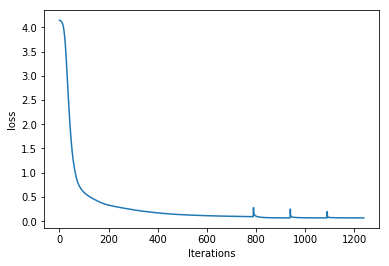

0.000500071147481364 False
[('loss', 0.068522975)]
0.00015496996628998482 False
[('loss', 0.06748304)]
1.4764368847043604e-05 True
========= Switching to adt_learn =========


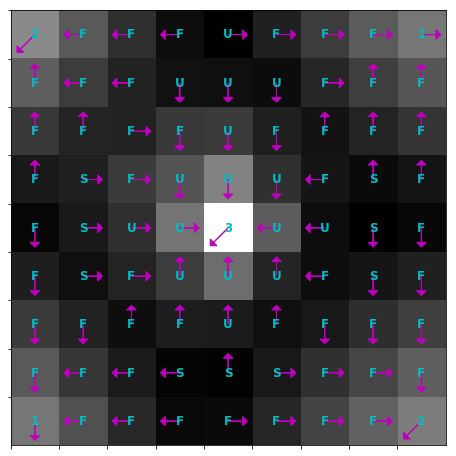

[[0.6138594  0.18063645 0.00943705 0.19602984 0.00003716]
 [0.10916753 0.7944561  0.08659725 0.00977918 0.00000004]
 [0.02220568 0.09604055 0.82846    0.05329363 0.00000013]
 [0.11754748 0.00089297 0.18720254 0.6849106  0.00944645]
 [0.00004015 0.         0.00000244 0.00023022 0.9997272 ]
 [0.24601953 0.01684931 0.19958428 0.03960174 0.4979451 ]
 [0.14578357 0.46905974 0.2859402  0.09903169 0.00018484]
 [0.23148766 0.2874673  0.40807676 0.07274825 0.00021994]
 [0.11383618 0.00495397 0.17418215 0.28845555 0.41857216]
 [0.00000115 0.         0.00000008 0.0000034  0.99999535]]


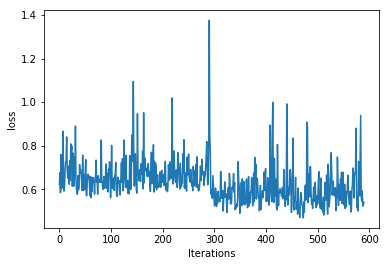

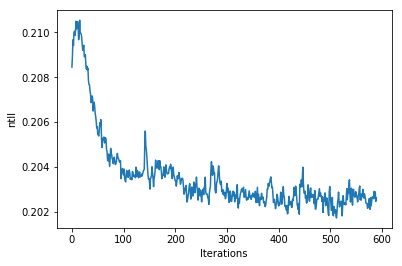

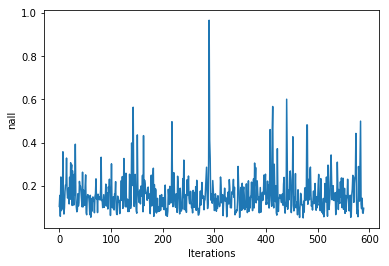

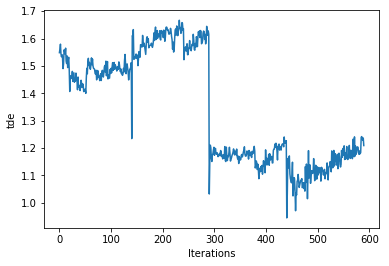

0.020774801470079988 False
[('nall', 0.1327874), ('loss', 0.92251563), ('ntll', 0.20319228), ('tde', 2.9326797)]
0.006010491186671882 False
[('nall', 0.082448795), ('loss', 0.86037296), ('ntll', 0.20348948), ('tde', 2.8721733)]
0.0005054156057047038 False
[('nall', 0.36986393), ('loss', 1.1207209), ('ntll', 0.20289025), ('tde', 2.7398336)]
0.0004732959663192039 False
[('nall', 0.085672826), ('loss', 0.8403234), ('ntll', 0.2021042), ('tde', 2.7627318)]
-0.0002535405568163838 True
========= Switching to adt_br =========


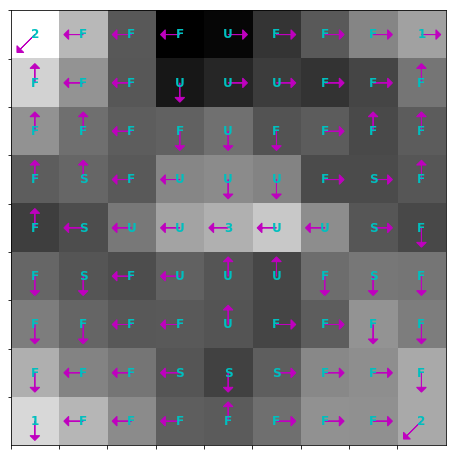

[[0.6688844  0.17955773 0.00328372 0.14809838 0.00017577]
 [0.11257062 0.79923743 0.08231327 0.00587863 0.00000003]
 [0.02038721 0.16834281 0.7709899  0.04027998 0.00000007]
 [0.17373158 0.000883   0.15733258 0.65474135 0.01331159]
 [0.00003724 0.         0.00000104 0.00015892 0.99980277]
 [0.00000015 0.00000173 0.00000002 0.00000001 0.9999981 ]
 [0.00132707 0.3316902  0.00467226 0.00055461 0.66175586]
 [0.00769566 0.25125578 0.16432148 0.02260803 0.55411905]
 [0.00331988 0.00248738 0.10046177 0.16365959 0.7300714 ]
 [0.00000003 0.         0.00000003 0.00000162 0.99999833]]


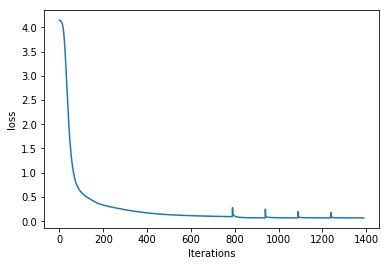

0.002248839888753014 False
[('loss', 0.119630285)]
0.0009703808057211644 False
[('loss', 0.101493336)]
0.00021883549384980647 False
[('loss', 0.095097564)]
9.567904143300551e-05 True
========= Switching to adt_learn =========


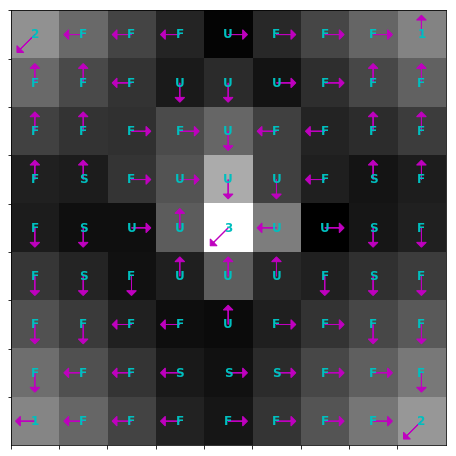

[[0.6688844  0.17955773 0.00328372 0.14809838 0.00017577]
 [0.11257062 0.79923743 0.08231327 0.00587863 0.00000003]
 [0.02038721 0.16834281 0.7709899  0.04027998 0.00000007]
 [0.17373158 0.000883   0.15733258 0.65474135 0.01331159]
 [0.00003724 0.         0.00000104 0.00015892 0.99980277]
 [0.00000015 0.00000173 0.00000002 0.00000001 0.9999981 ]
 [0.00132707 0.3316902  0.00467226 0.00055461 0.66175586]
 [0.00769566 0.25125578 0.16432148 0.02260803 0.55411905]
 [0.00331988 0.00248738 0.10046177 0.16365959 0.7300714 ]
 [0.00000003 0.         0.00000003 0.00000162 0.99999833]]


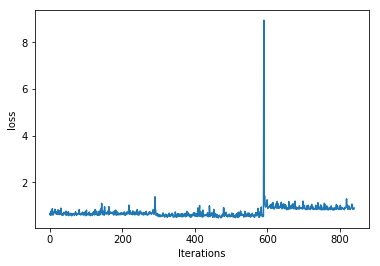

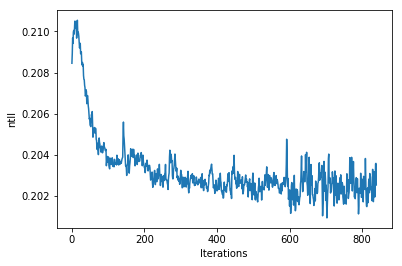

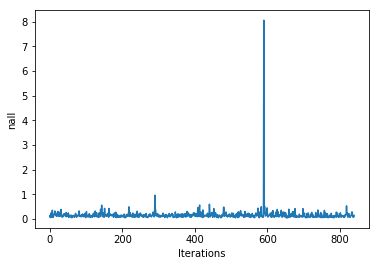

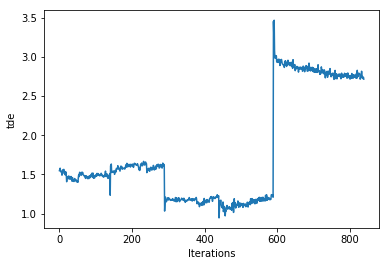

-0.001360589673682278 True
========= Switching to adt_br =========


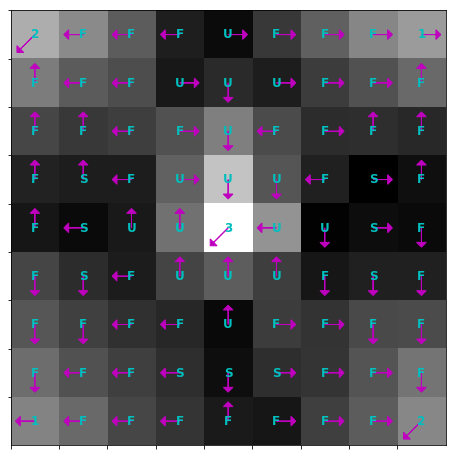

[[0.7399891  0.12978369 0.00269186 0.12743373 0.00010163]
 [0.12390638 0.77519155 0.09386837 0.00703374 0.00000002]
 [0.01882651 0.09790953 0.83255386 0.05071009 0.00000004]
 [0.14527711 0.00030323 0.15580757 0.6905983  0.00801377]
 [0.00004796 0.         0.00000164 0.00024604 0.9997043 ]
 [0.00000023 0.00000156 0.00000002 0.00000001 0.9999982 ]
 [0.00181734 0.35793835 0.00459488 0.0004582  0.63519126]
 [0.00947835 0.32623532 0.17351668 0.02182575 0.46894395]
 [0.00428842 0.00371154 0.1508156  0.21607663 0.6251078 ]
 [0.00000006 0.         0.00000007 0.00000334 0.99999654]]


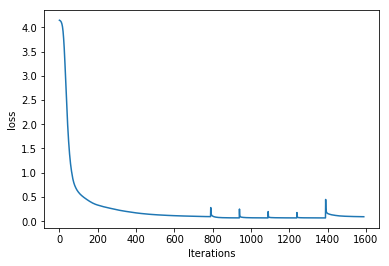

0.0003318042682857232 False
[('loss', 0.08927525)]
0.00010415906184362728 False
[('loss', 0.08851434)]
1.0974646830680553e-05 True
========= Switching to adt_learn =========


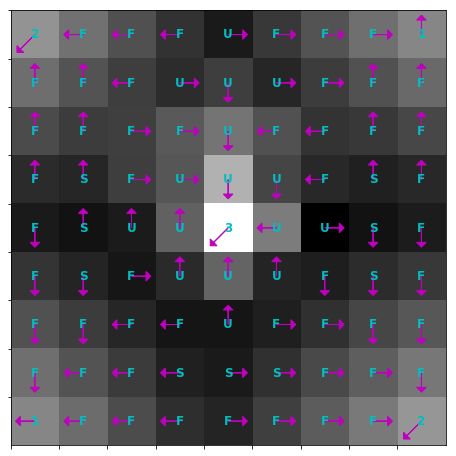

[[0.7399891  0.12978369 0.00269186 0.12743373 0.00010163]
 [0.12390638 0.77519155 0.09386837 0.00703374 0.00000002]
 [0.01882651 0.09790953 0.83255386 0.05071009 0.00000004]
 [0.14527711 0.00030323 0.15580757 0.6905983  0.00801377]
 [0.00004796 0.         0.00000164 0.00024604 0.9997043 ]
 [0.00000023 0.00000156 0.00000002 0.00000001 0.9999982 ]
 [0.00181734 0.35793835 0.00459488 0.0004582  0.63519126]
 [0.00947835 0.32623532 0.17351668 0.02182575 0.46894395]
 [0.00428842 0.00371154 0.1508156  0.21607663 0.6251078 ]
 [0.00000006 0.         0.00000007 0.00000334 0.99999654]]


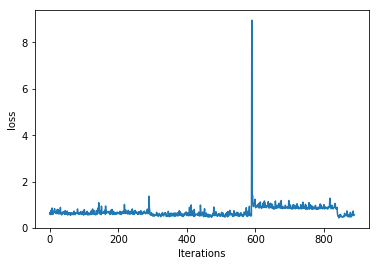

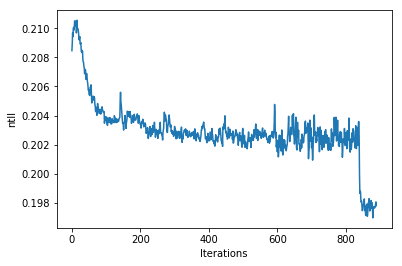

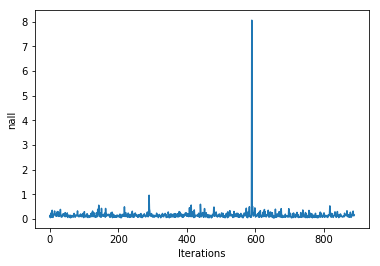

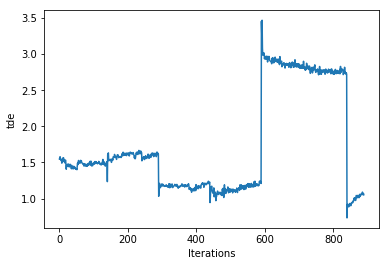

0.002716577292061089 False
[('nall', 0.19850686), ('loss', 0.58409774), ('ntll', 0.19758888), ('tde', 0.9400099)]
0.0009054663840836641 False
[('nall', 0.060736254), ('loss', 0.43960202), ('ntll', 0.19777462), ('tde', 0.90545565)]
-0.0006044174690987663 True
========= Switching to adt_br =========


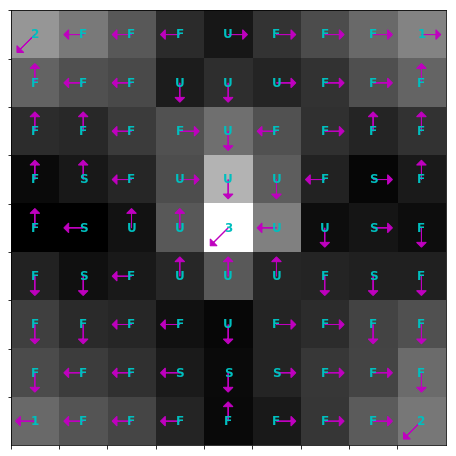

[[0.77327144 0.09823497 0.00247345 0.12597224 0.00004789]
 [0.0932526  0.782146   0.1175247  0.00707675 0.00000001]
 [0.01061718 0.11179253 0.8290293  0.04856088 0.00000001]
 [0.12003122 0.0002468  0.1308503  0.744752   0.0041196 ]
 [0.00005401 0.         0.00000122 0.00027751 0.9996673 ]
 [0.0000008  0.00000095 0.00000002 0.00000001 0.9999982 ]
 [0.00490304 0.33733785 0.00576719 0.00073804 0.6512538 ]
 [0.01506721 0.36090636 0.1726452  0.02536891 0.42601228]
 [0.00582913 0.00686407 0.19662534 0.23636386 0.5543176 ]
 [0.00000009 0.         0.00000006 0.00000465 0.99999523]]


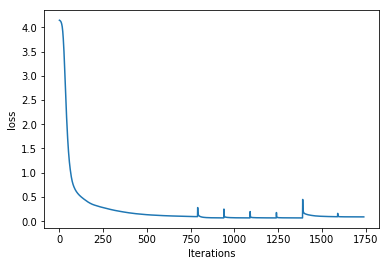

0.0003747319659980698 False
[('loss', 0.08828617)]
0.00010943942261536228 False
[('loss', 0.08776279)]
8.062104893775018e-06 True
========= Switching to adt_learn =========


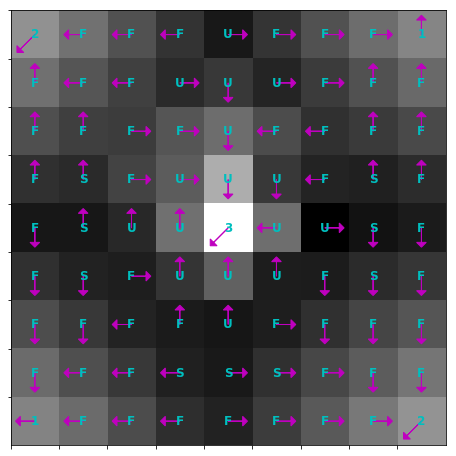

[[0.77327144 0.09823497 0.00247345 0.12597224 0.00004789]
 [0.0932526  0.782146   0.1175247  0.00707675 0.00000001]
 [0.01061718 0.11179253 0.8290293  0.04856088 0.00000001]
 [0.12003122 0.0002468  0.1308503  0.744752   0.0041196 ]
 [0.00005401 0.         0.00000122 0.00027751 0.9996673 ]
 [0.0000008  0.00000095 0.00000002 0.00000001 0.9999982 ]
 [0.00490304 0.33733785 0.00576719 0.00073804 0.6512538 ]
 [0.01506721 0.36090636 0.1726452  0.02536891 0.42601228]
 [0.00582913 0.00686407 0.19662534 0.23636386 0.5543176 ]
 [0.00000009 0.         0.00000006 0.00000465 0.99999523]]


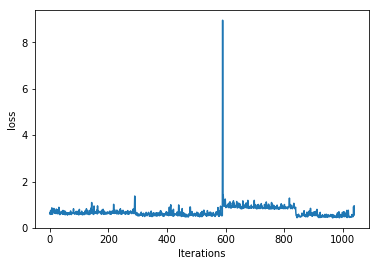

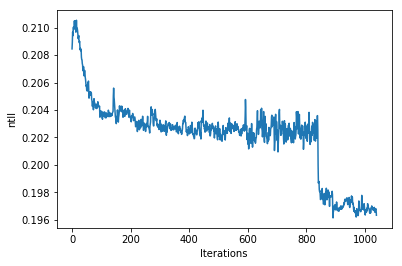

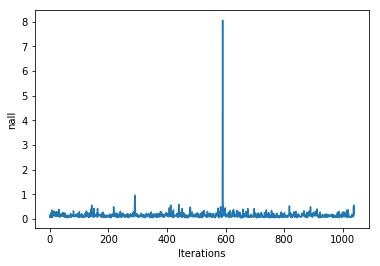

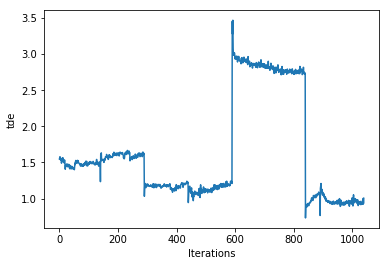

0.002803676796703645 False
[('nall', 0.07407044), ('loss', 0.41516632), ('ntll', 0.19773173), ('tde', 0.71682054)]
0.0011607928414477861 False
[('nall', 0.17654562), ('loss', 0.5210725), ('ntll', 0.1987847), ('tde', 0.7287108)]
2.869080216754571e-06 True
========= Switching to adt_br =========


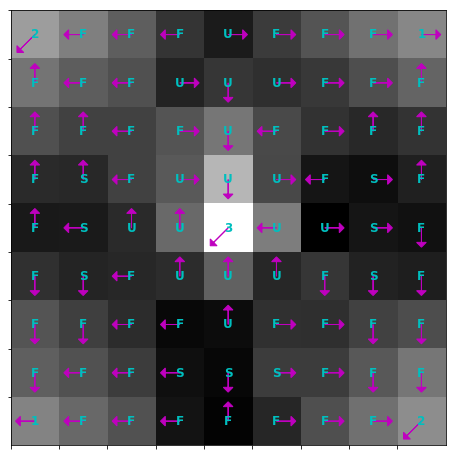

[[0.7219804  0.12501928 0.002815   0.15013176 0.00005352]
 [0.08873177 0.7708131  0.13359971 0.0068554  0.        ]
 [0.00867973 0.13810346 0.8099717  0.04324508 0.00000001]
 [0.1158625  0.00028918 0.15916345 0.7204164  0.00426841]
 [0.00003337 0.         0.0000009  0.00015831 0.9998074 ]
 [0.00000037 0.00000059 0.00000002 0.         0.99999905]
 [0.00420698 0.2993856  0.0085025  0.00027877 0.6876262 ]
 [0.01699361 0.34817314 0.16874686 0.01353287 0.45255342]
 [0.01099955 0.01184669 0.21129459 0.25429985 0.5115593 ]
 [0.00000008 0.         0.00000004 0.00000262 0.99999726]]


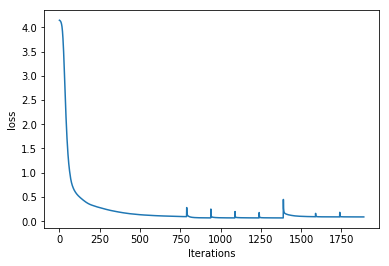

0.0002909935186175461 False
[('loss', 0.08729652)]
8.524728731604103e-05 True
========= Switching to adt_learn =========


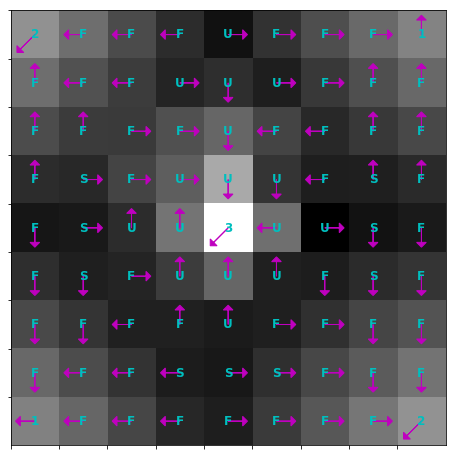

[[0.7219804  0.12501928 0.002815   0.15013176 0.00005352]
 [0.08873177 0.7708131  0.13359971 0.0068554  0.        ]
 [0.00867973 0.13810346 0.8099717  0.04324508 0.00000001]
 [0.1158625  0.00028918 0.15916345 0.7204164  0.00426841]
 [0.00003337 0.         0.0000009  0.00015831 0.9998074 ]
 [0.00000037 0.00000059 0.00000002 0.         0.99999905]
 [0.00420698 0.2993856  0.0085025  0.00027877 0.6876262 ]
 [0.01699361 0.34817314 0.16874686 0.01353287 0.45255342]
 [0.01099955 0.01184669 0.21129459 0.25429985 0.5115593 ]
 [0.00000008 0.         0.00000004 0.00000262 0.99999726]]


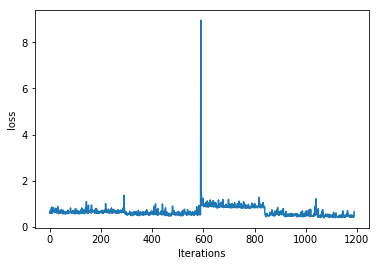

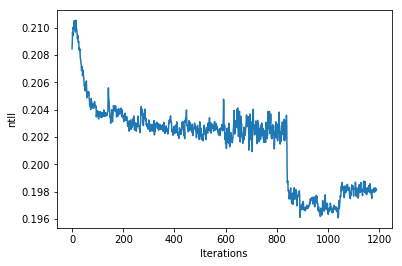

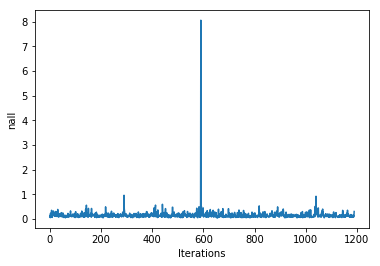

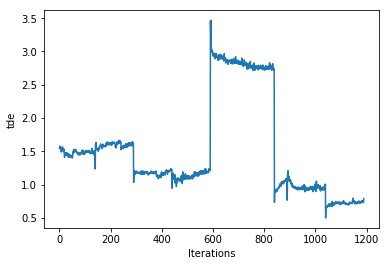

0.0012317577158274245 False
[('nall', 0.16228963), ('loss', 0.53844655), ('ntll', 0.19908622), ('tde', 0.88535327)]
0.0003635000379601312 False
[('nall', 0.28151697), ('loss', 0.6595798), ('ntll', 0.19995683), ('tde', 0.8905301)]
-0.0002456912916056432 True
========= Switching to adt_br =========


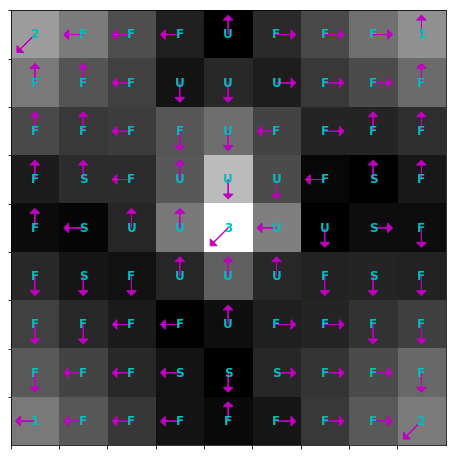

[[0.7469029  0.11968391 0.00401274 0.1293641  0.00003636]
 [0.09437134 0.7460403  0.15322569 0.00636266 0.        ]
 [0.00711298 0.11192776 0.84523004 0.03572927 0.        ]
 [0.1257367  0.00019814 0.20047168 0.67003286 0.00356064]
 [0.00003349 0.         0.00000094 0.00011905 0.99984646]
 [0.00000022 0.00000039 0.00000004 0.         0.9999994 ]
 [0.00383408 0.27513444 0.0192169  0.00012939 0.70168513]
 [0.01751147 0.3407448  0.18209042 0.00791585 0.4517375 ]
 [0.0200919  0.02226816 0.2561995  0.27481946 0.42662096]
 [0.0000001  0.         0.00000003 0.00000154 0.99999833]]


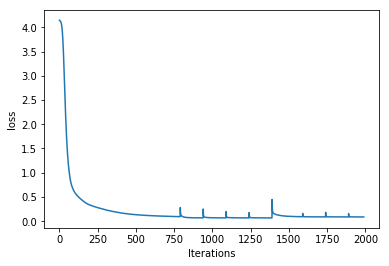

0.00026353204629573024 False
[('loss', 0.08703671)]
7.99752540714278e-05 True
========= Switching to adt_learn =========


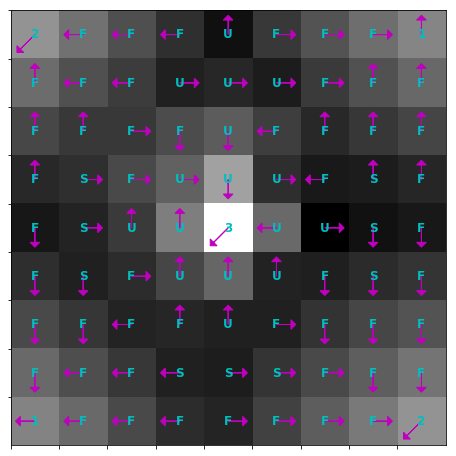

[[0.7469029  0.11968391 0.00401274 0.1293641  0.00003636]
 [0.09437134 0.7460403  0.15322569 0.00636266 0.        ]
 [0.00711298 0.11192776 0.84523004 0.03572927 0.        ]
 [0.1257367  0.00019814 0.20047168 0.67003286 0.00356064]
 [0.00003349 0.         0.00000094 0.00011905 0.99984646]
 [0.00000022 0.00000039 0.00000004 0.         0.9999994 ]
 [0.00383408 0.27513444 0.0192169  0.00012939 0.70168513]
 [0.01751147 0.3407448  0.18209042 0.00791585 0.4517375 ]
 [0.0200919  0.02226816 0.2561995  0.27481946 0.42662096]
 [0.0000001  0.         0.00000003 0.00000154 0.99999833]]


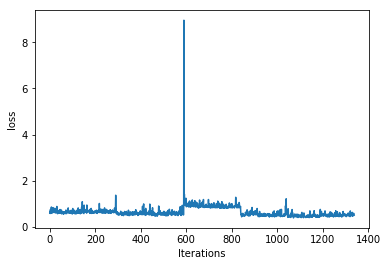

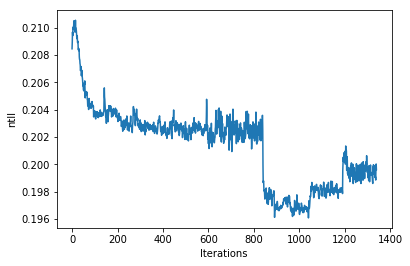

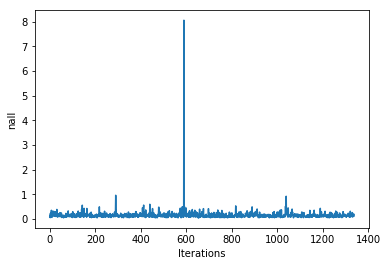

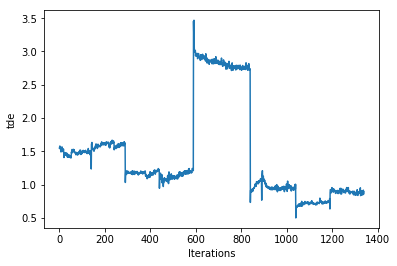

0.0024090798662490336 False
[('nall', 0.17138216), ('loss', 0.5354563), ('ntll', 0.19693589), ('tde', 0.83569133)]
0.000999950453071242 False
[('nall', 0.0852028), ('loss', 0.4576323), ('ntll', 0.19624892), ('tde', 0.88090307)]
-0.00021730620654323597 True
========= Switching to adt_br =========


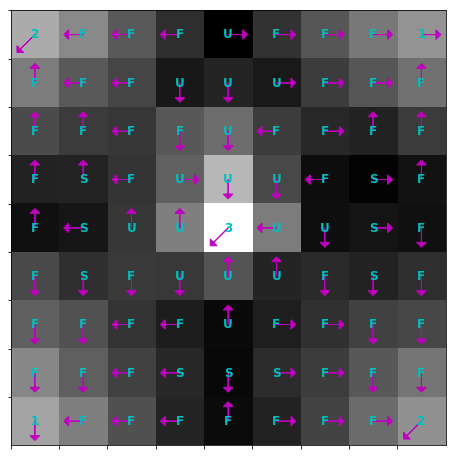

[[0.70312995 0.15517735 0.00185275 0.13980384 0.00003613]
 [0.09269632 0.7974175  0.10394459 0.00594156 0.        ]
 [0.00869738 0.11181211 0.82518274 0.05430777 0.        ]
 [0.0974969  0.0000856  0.18214789 0.71807086 0.00219877]
 [0.00002675 0.         0.00000116 0.00014669 0.9998254 ]
 [0.00000011 0.00000022 0.         0.         0.99999964]
 [0.00303191 0.21960443 0.00254957 0.00013271 0.7746814 ]
 [0.01744027 0.32435152 0.13429458 0.01359371 0.51031995]
 [0.0092639  0.01064575 0.3342632  0.259299   0.3865282 ]
 [0.00000006 0.         0.00000004 0.00000268 0.99999726]]


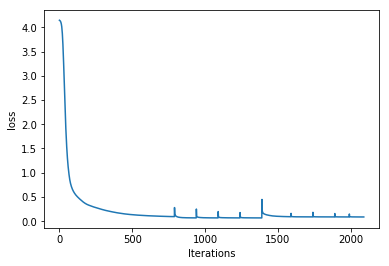

0.000424047257004381 False
[('loss', 0.0878073)]
0.00013350813038492967 False
[('loss', 0.08697253)]
1.0678250350431378e-05 True
========= Switching to adt_learn =========


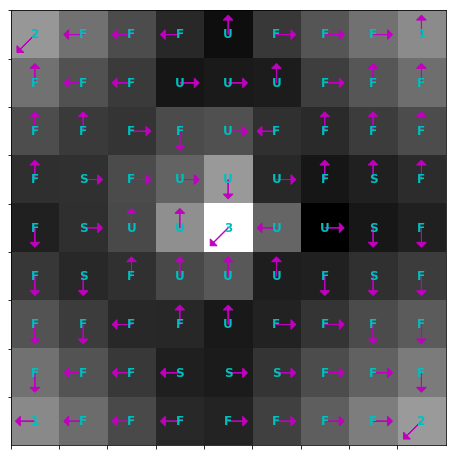

[[0.70312995 0.15517735 0.00185275 0.13980384 0.00003613]
 [0.09269632 0.7974175  0.10394459 0.00594156 0.        ]
 [0.00869738 0.11181211 0.82518274 0.05430777 0.        ]
 [0.0974969  0.0000856  0.18214789 0.71807086 0.00219877]
 [0.00002675 0.         0.00000116 0.00014669 0.9998254 ]
 [0.00000011 0.00000022 0.         0.         0.99999964]
 [0.00303191 0.21960443 0.00254957 0.00013271 0.7746814 ]
 [0.01744027 0.32435152 0.13429458 0.01359371 0.51031995]
 [0.0092639  0.01064575 0.3342632  0.259299   0.3865282 ]
 [0.00000006 0.         0.00000004 0.00000268 0.99999726]]


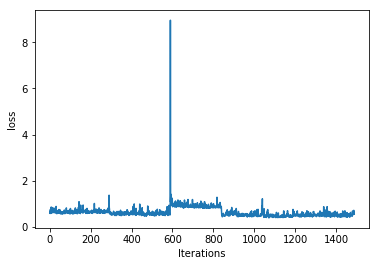

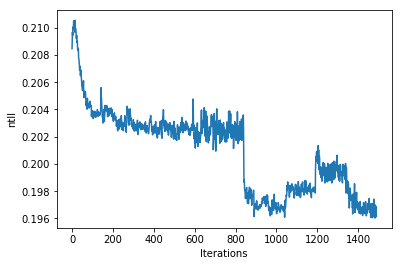

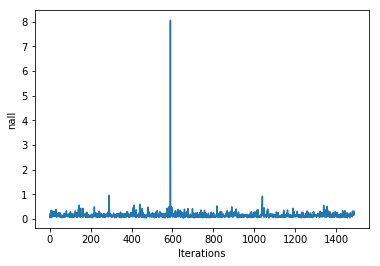

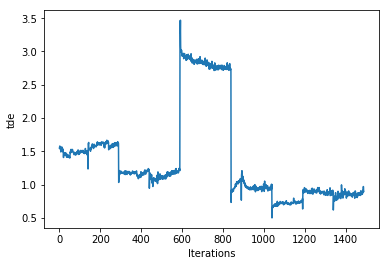

-0.00018381804406714125 True
========= Switching to adt_br =========


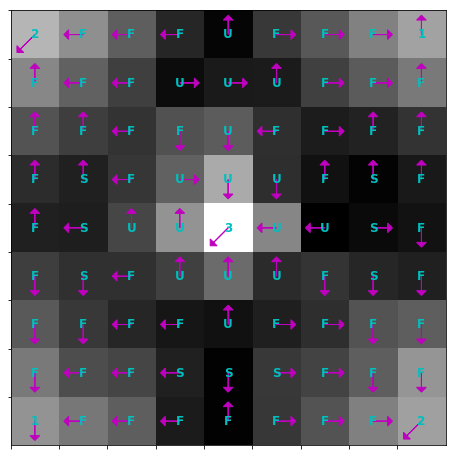

[[0.6517797  0.2090382  0.00230648 0.13683191 0.00004372]
 [0.09198632 0.79258233 0.10947481 0.00595647 0.        ]
 [0.00857725 0.11187137 0.82119083 0.05836053 0.        ]
 [0.09717275 0.00006559 0.18624231 0.7141888  0.00233053]
 [0.00002199 0.         0.00000099 0.00011809 0.99985886]
 [0.00000003 0.00000028 0.         0.         0.99999964]
 [0.00080678 0.24271366 0.00248964 0.00012681 0.7538631 ]
 [0.00545831 0.3574444  0.1549889  0.01828194 0.46382648]
 [0.00328596 0.00633427 0.35009307 0.2740726  0.36621407]
 [0.00000002 0.         0.00000003 0.00000134 0.99999857]]


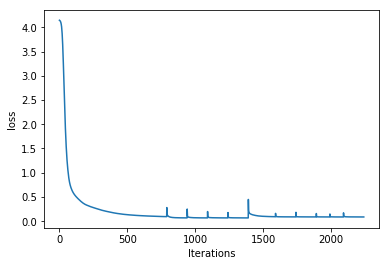

0.00027613850737534003 False
[('loss', 0.08742841)]
7.922638135023651e-05 True
========= Switching to adt_learn =========


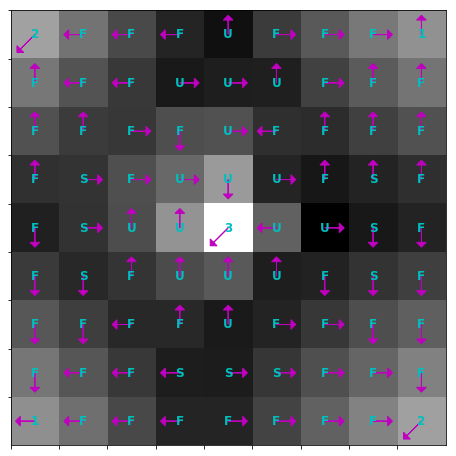

[[0.6517797  0.2090382  0.00230648 0.13683191 0.00004372]
 [0.09198632 0.79258233 0.10947481 0.00595647 0.        ]
 [0.00857725 0.11187137 0.82119083 0.05836053 0.        ]
 [0.09717275 0.00006559 0.18624231 0.7141888  0.00233053]
 [0.00002199 0.         0.00000099 0.00011809 0.99985886]
 [0.00000003 0.00000028 0.         0.         0.99999964]
 [0.00080678 0.24271366 0.00248964 0.00012681 0.7538631 ]
 [0.00545831 0.3574444  0.1549889  0.01828194 0.46382648]
 [0.00328596 0.00633427 0.35009307 0.2740726  0.36621407]
 [0.00000002 0.         0.00000003 0.00000134 0.99999857]]


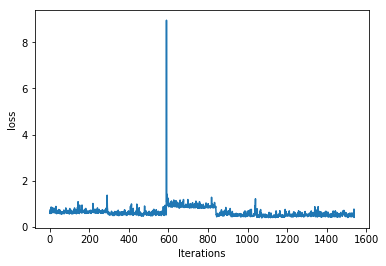

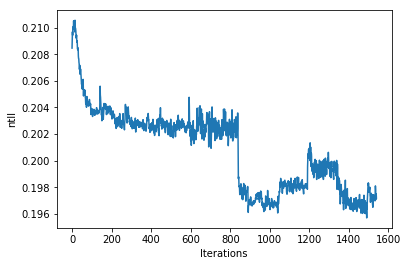

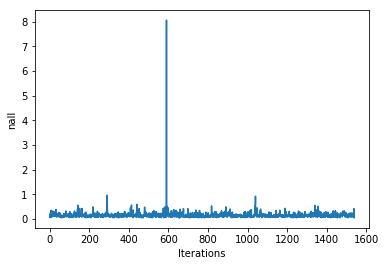

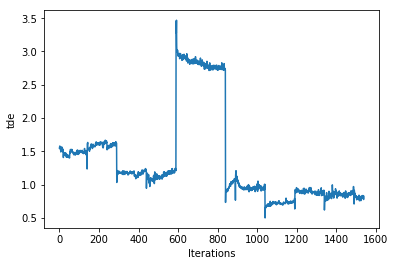

0.0007712677518288229 False
[('nall', 0.082724884), ('loss', 0.52960247), ('ntll', 0.20150518), ('tde', 1.2268621)]
-0.00020073629627347905 True
========= Switching to adt_br =========


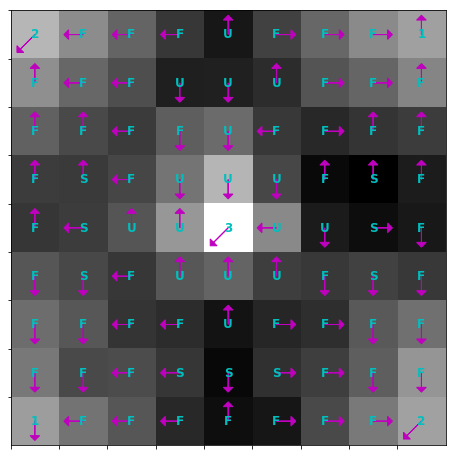

[[0.60934955 0.23270273 0.00263124 0.15527102 0.00004549]
 [0.09891955 0.773341   0.12155773 0.00618165 0.        ]
 [0.0067788  0.09163919 0.8519023  0.04967971 0.        ]
 [0.07958408 0.00005864 0.24622521 0.6720474  0.00208471]
 [0.00001421 0.         0.00000126 0.00009482 0.99988973]
 [0.00000001 0.00000037 0.         0.         0.99999964]
 [0.00040434 0.2968754  0.00364728 0.00020646 0.6988665 ]
 [0.00254984 0.3989755  0.19793727 0.02636433 0.37417305]
 [0.00151305 0.0097213  0.42210987 0.28615925 0.28049657]
 [0.00000001 0.         0.00000005 0.00000139 0.99999857]]


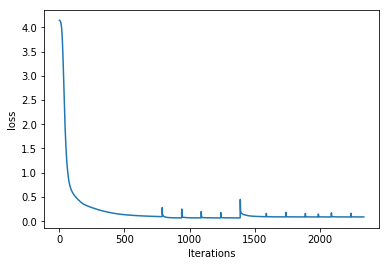

0.00043416817076638657 False
[('loss', 0.08843651)]
0.0001232469414952924 False
[('loss', 0.08791695)]
8.33763304215983e-06 True
========= Switching to adt_learn =========


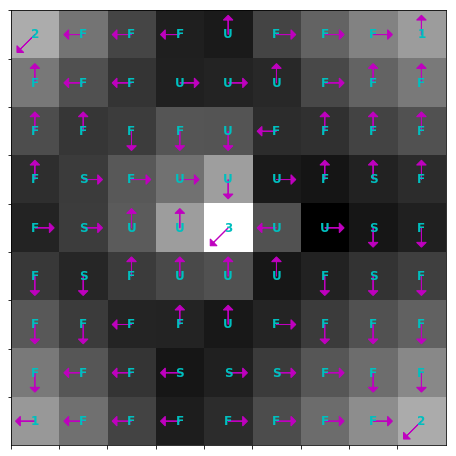

[[0.60934955 0.23270273 0.00263124 0.15527102 0.00004549]
 [0.09891955 0.773341   0.12155773 0.00618165 0.        ]
 [0.0067788  0.09163919 0.8519023  0.04967971 0.        ]
 [0.07958408 0.00005864 0.24622521 0.6720474  0.00208471]
 [0.00001421 0.         0.00000126 0.00009482 0.99988973]
 [0.00000001 0.00000037 0.         0.         0.99999964]
 [0.00040434 0.2968754  0.00364728 0.00020646 0.6988665 ]
 [0.00254984 0.3989755  0.19793727 0.02636433 0.37417305]
 [0.00151305 0.0097213  0.42210987 0.28615925 0.28049657]
 [0.00000001 0.         0.00000005 0.00000139 0.99999857]]


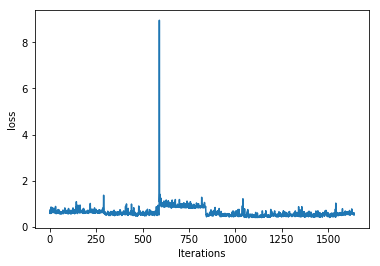

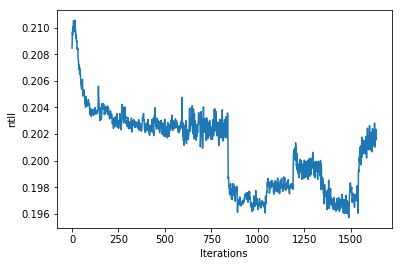

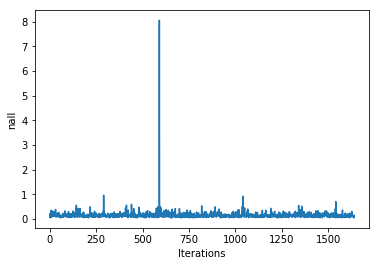

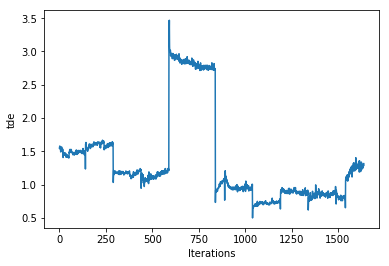

0.0009051237615789119 False
[('nall', 0.059358116), ('loss', 0.5056654), ('ntll', 0.1999438), ('tde', 1.2318177)]
0.00027920887665529846 False
[('nall', 0.090929836), ('loss', 0.54471457), ('ntll', 0.19905916), ('tde', 1.2736279)]
0.00018866393700613207 False
[('nall', 0.13239951), ('loss', 0.5708099), ('ntll', 0.19925202), ('tde', 1.1957918)]
0.0002239769132080804 False
[('nall', 0.14642961), ('loss', 0.5792534), ('ntll', 0.20064089), ('tde', 1.1609142)]
-0.0004448531513059617 True
========= Switching to adt_br =========


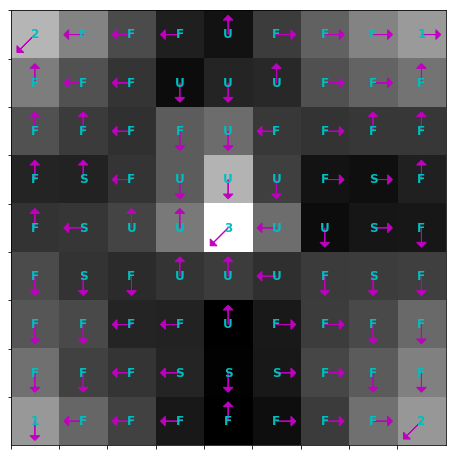

[[0.7133962  0.17343572 0.00182459 0.11132535 0.00001813]
 [0.10631829 0.7743725  0.11457693 0.00473221 0.        ]
 [0.00492688 0.06237825 0.8929246  0.03977029 0.        ]
 [0.07898109 0.00001826 0.23344193 0.6860951  0.00146353]
 [0.00001322 0.         0.00000107 0.00009522 0.99989045]
 [0.00000001 0.00000029 0.         0.         0.99999964]
 [0.00035642 0.31962696 0.00214161 0.00064664 0.6772284 ]
 [0.00200352 0.4330982  0.13854775 0.08851252 0.3378379 ]
 [0.0007899  0.00279658 0.45792204 0.25462535 0.28386617]
 [0.         0.         0.00000004 0.00000087 0.99999905]]


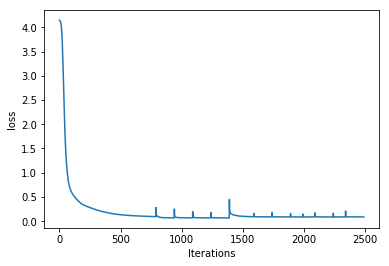

0.00046295358961513075 False
[('loss', 0.08952616)]
0.0001423603138013753 False
[('loss', 0.088639185)]
1.3133989747064882e-05 True
========= Switching to adt_learn =========


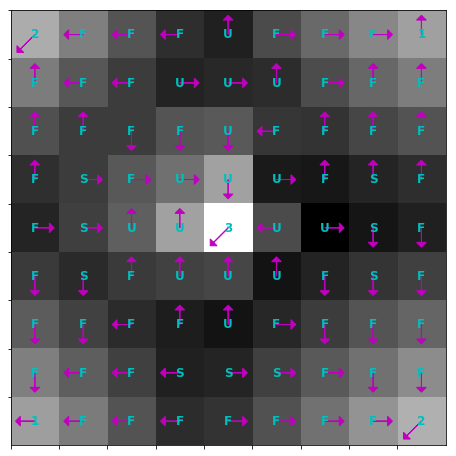

[[0.7133962  0.17343572 0.00182459 0.11132535 0.00001813]
 [0.10631829 0.7743725  0.11457693 0.00473221 0.        ]
 [0.00492688 0.06237825 0.8929246  0.03977029 0.        ]
 [0.07898109 0.00001826 0.23344193 0.6860951  0.00146353]
 [0.00001322 0.         0.00000107 0.00009522 0.99989045]
 [0.00000001 0.00000029 0.         0.         0.99999964]
 [0.00035642 0.31962696 0.00214161 0.00064664 0.6772284 ]
 [0.00200352 0.4330982  0.13854775 0.08851252 0.3378379 ]
 [0.0007899  0.00279658 0.45792204 0.25462535 0.28386617]
 [0.         0.         0.00000004 0.00000087 0.99999905]]


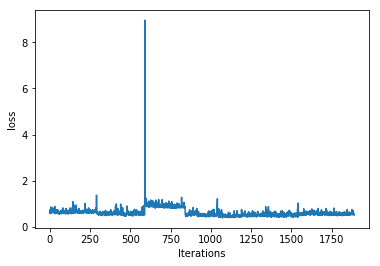

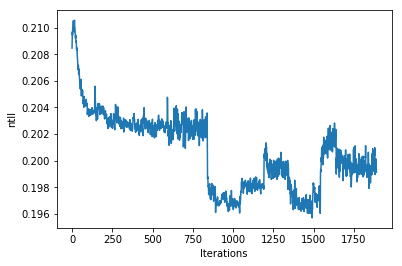

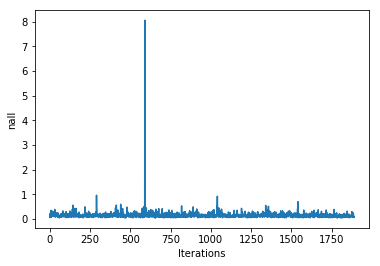

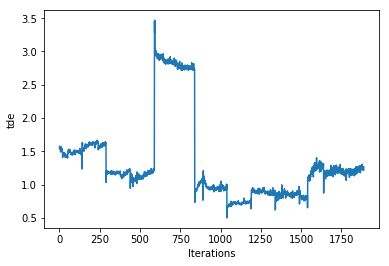

0.003624651952951904 False
[('nall', 0.14080068), ('loss', 0.6781773), ('ntll', 0.20515367), ('tde', 1.6611147)]
0.0013158144172590652 False
[('nall', 0.129536), ('loss', 0.6763091), ('ntll', 0.20690352), ('tde', 1.6993481)]
-3.7939456930538115e-05 True
========= Switching to adt_br =========


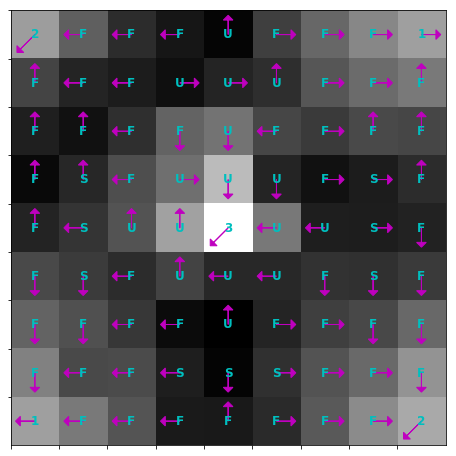

[[0.58997905 0.33914238 0.00225888 0.06859817 0.0000215 ]
 [0.08058296 0.830082   0.08513953 0.00419551 0.        ]
 [0.00452604 0.10177714 0.8301392  0.06355761 0.        ]
 [0.0524353  0.00000993 0.32012808 0.62619275 0.00123394]
 [0.00000884 0.         0.00000205 0.0000794  0.99990964]
 [0.         0.00000023 0.         0.         0.99999976]
 [0.00006638 0.26098454 0.00049399 0.00025484 0.73820025]
 [0.00069646 0.42496872 0.08926842 0.08790933 0.39715707]
 [0.0002941  0.00176994 0.50357497 0.21015222 0.28420877]
 [0.         0.         0.00000006 0.00000072 0.99999917]]


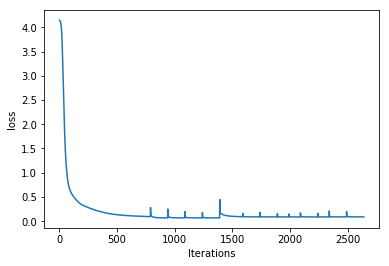

0.0005148493080866171 False
[('loss', 0.08875404)]
0.00015496943001807223 False
[('loss', 0.08787968)]
1.2942242874528293e-05 True
========= Switching to adt_learn =========


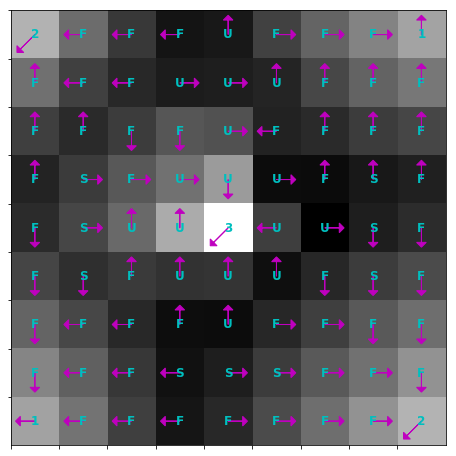

[[0.58997905 0.33914238 0.00225888 0.06859817 0.0000215 ]
 [0.08058296 0.830082   0.08513953 0.00419551 0.        ]
 [0.00452604 0.10177714 0.8301392  0.06355761 0.        ]
 [0.0524353  0.00000993 0.32012808 0.62619275 0.00123394]
 [0.00000884 0.         0.00000205 0.0000794  0.99990964]
 [0.         0.00000023 0.         0.         0.99999976]
 [0.00006638 0.26098454 0.00049399 0.00025484 0.73820025]
 [0.00069646 0.42496872 0.08926842 0.08790933 0.39715707]
 [0.0002941  0.00176994 0.50357497 0.21015222 0.28420877]
 [0.         0.         0.00000006 0.00000072 0.99999917]]


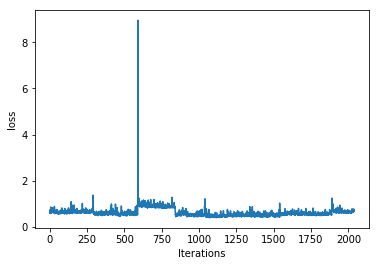

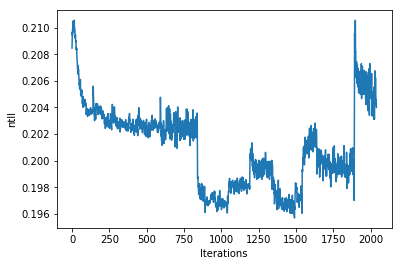

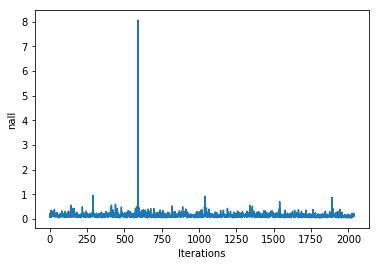

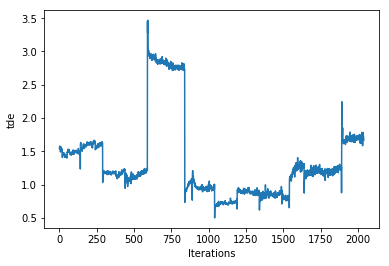

0.0018653357558462349 False
[('nall', 0.10205991), ('loss', 0.61444354), ('ntll', 0.20894806), ('tde', 1.5171776)]
0.00023026902683497368 False
[('nall', 0.11041545), ('loss', 0.6202041), ('ntll', 0.20934403), ('tde', 1.5022229)]
0.00020900438792563052 False
[('nall', 0.22715117), ('loss', 0.7474264), ('ntll', 0.20827144), ('tde', 1.560019)]
4.943212624466016e-05 True
========= Switching to adt_br =========


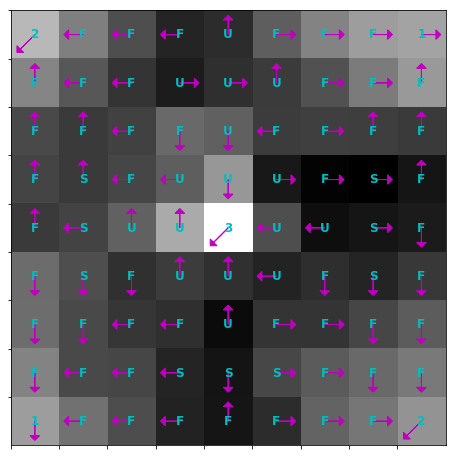

[[0.60965055 0.30875984 0.00227315 0.07929077 0.00002572]
 [0.13656548 0.7502636  0.10860679 0.00456417 0.        ]
 [0.00452208 0.0494823  0.900829   0.04516659 0.        ]
 [0.08652103 0.00000518 0.34011614 0.57106817 0.00228941]
 [0.00000594 0.         0.00000079 0.00002658 0.99996674]
 [0.         0.00000021 0.         0.         0.99999976]
 [0.00005297 0.26396564 0.00067171 0.00033806 0.73497164]
 [0.00060137 0.44828737 0.10954051 0.09083463 0.35073608]
 [0.00026361 0.00278288 0.54113376 0.2059042  0.24991553]
 [0.         0.         0.00000006 0.00000056 0.9999994 ]]


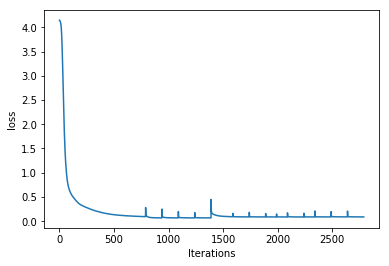

0.0005751656852707309 False
[('loss', 0.0885996)]
0.0001697288074902577 False
[('loss', 0.08771703)]
1.350986521200405e-05 True
========= Switching to adt_learn =========


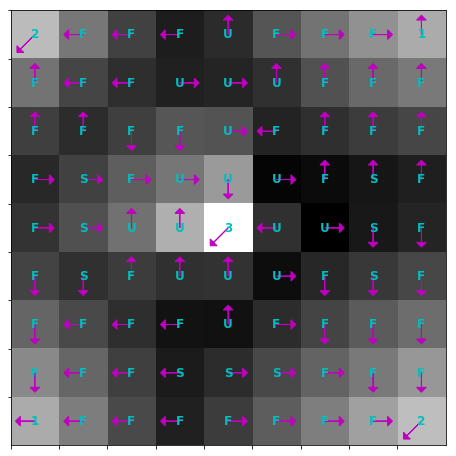

[[0.60965055 0.30875984 0.00227315 0.07929077 0.00002572]
 [0.13656548 0.7502636  0.10860679 0.00456417 0.        ]
 [0.00452208 0.0494823  0.900829   0.04516659 0.        ]
 [0.08652103 0.00000518 0.34011614 0.57106817 0.00228941]
 [0.00000594 0.         0.00000079 0.00002658 0.99996674]
 [0.         0.00000021 0.         0.         0.99999976]
 [0.00005297 0.26396564 0.00067171 0.00033806 0.73497164]
 [0.00060137 0.44828737 0.10954051 0.09083463 0.35073608]
 [0.00026361 0.00278288 0.54113376 0.2059042  0.24991553]
 [0.         0.         0.00000006 0.00000056 0.9999994 ]]


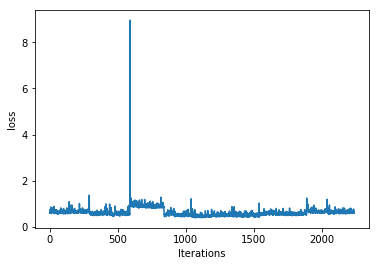

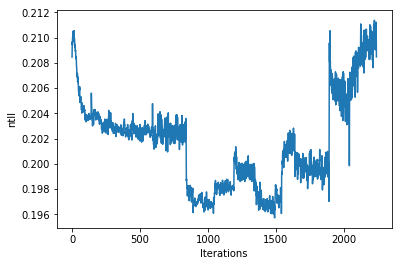

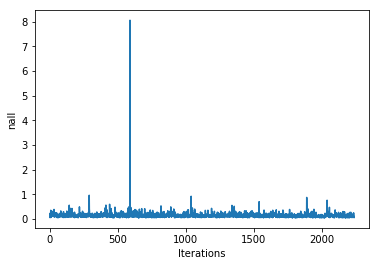

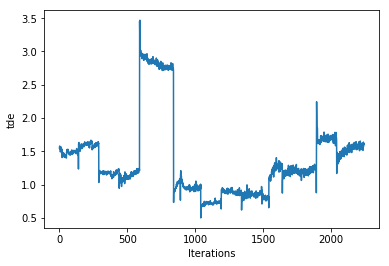

In [ ]:
# I built in a simple update-switcher so I no longer needed to manually stop training and switch update fns

while total_train_time < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, true_qs=true_qs)        
    if i % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, true_qs=true_qs)
        for k, v in train_log.items():
            full_train_logs['%s_evals' % k].append(v)
        for k, v in val_log.items():
            if 'val_%s_evals' % k in full_train_logs:
                full_train_logs['val_%s_evals' % k].append(v)
    
    if i % 1000 == 0:
        if i != 0:
            pu = update
            losses = full_train_logs['val_loss_evals'][(-i//20):]
            update = update_switcher(update, update_progression, losses, slope_threshold=1e-4)
            if pu != update:
                full_train_logs = mode_logs[update]
                print("========= Switching to {} =========".format(update))
                i = 0
            else:
                print([(key,val_log[key]) for key in val_log.keys()])
        else:
            print([(key,val_log[key]) for key in val_log.keys()])
            
    if i % 5000 == 0:
        q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
        plot_values(mdp, q_vals)
        plt.show()
        adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
        print(softmax(adt_probs))
        
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][10:])
                plt.show()
    i += 1
    total_train_time +=1

In [72]:
# # def train_multi_task(nn_rollouts, idxes, losses, base_opt):
    
# # train_idxes, val_idxes = idxes
# # val_demo_batch = sample_batch(nn_rollouts, val_idxes)
# num_tasks = 2
# scales = np.ones([num_tasks]) #[tf.placeholder(tf.float32, 1, name="scale") for _ in range(num_tasks)]
# opts = [tf.train.AdamOptimizer(alpha, beta1, beta2) for _ in range(num_tasks)]
# loss_fns = np.array([neg_avg_act_log_likelihood, neg_avg_adt_log_likelihood, adt_td_err, adt_td_err_sgq, adt_td_err_sgt])
# loss_fns_titles = np.array(['nall', 'ntll', 'tde', 'tde_sq','tde_st', 'loss'])
# loss_configs = [[0,1],[2]]

# losses = [loss_fns[config] for config in loss_configs]
# # # add total loss to the list of losses 
# # losses = [[sum(losses[t])] + list(losses[t]) for t in tasks]
# loss_titles = [loss_fns_titles[config] for config in loss_configs]



# all_gvs = [opts[i].compute_gradients(sum(losses[i])) for i in range(num_tasks)]

# def scale_gvs(gvs, scales):
#     return [(gv[i][0] * scales[i], gv[i][1]) for i in range(num_tasks)]

# # elems = (all_gvs, scale)
# # scaled_gvs = tf.map_fn(scale_grad, elems)

# # scaled_gvs = [(all_gvs[i][0] * scales[i], all_gvs[i][1]) for i in range(num_tasks)]

# print(len((all_gvs[0][0] * scales[0], all_gvs[0][1])))
# print(scaled_gvs[0][1])
# updates = [opts[i].apply_gradients(scaled_gvs[i]) for i in range(num_tasks)]




# while total_train_time < n_training_iters:
    
#     demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
#     feed_dict = {
#         demo_obs_t_feats_ph: demo_batch[1],
#         demo_act_t_ph: demo_batch[2],
#         demo_next_obs_t_feats_ph: demo_batch[4],
#         demo_dir_t_ph: demo_batch[5],
#         demo_tile_t_ph: demo_batch[6],
#         demo_batch_size_ph: demo_batch[2].shape[0],
#         constraint_obs_t_feats_ph: constraints[0],
#         constraint_act_t_ph: constraints[1],
#         constraint_rew_t_ph: constraints[2],
#         constraint_next_obs_t_feats_ph: constraints[3],
#         constraint_tile_t_ph: constraints[4],
#         constraint_batch_size_ph: constraints[0].shape[0]
#     }
    
#     # Scaling the loss functions based on the algorithm choice
#     loss_data = {}
#     gvs_data = {}
#     scale = {}
#     mask = None
#     masks = {}

#     # This is MGDA
#     for t in range(num_tasks):
#         # Compute gradients of each loss function wrt parameters
#         loss_data[t], gv_data[t] = sess.run([losses[t],gvs[t]], feed_dict=feed_dict)
#         #g_loss_data[t] = loss_data[t][1:]

#     # Normalize all gradients
# #     grad_data, grad_var_data = zip(*gv_data)
# #     gn = gradient_normalizers(grad_data, loss_data, "loss+")
# #     for t in range(num_tasks):
# #         for gr_i in range(len(grad_data[t])):
# #             grads[t][gr_i] = grads[t][gr_i] / gn[t]

#     # Frank-Wolfe iteration to compute scales.
#     sol, min_norm = MinNormSolverNumpy.find_min_norm_element([grads[t] for t in range(num_tasks)])

#     # Scaled back-propagation
#     for i,s in enumerate(scales):
#         feed_dict[s] = sol[i]
#     for t in range(num_tasks):
#         # Inefficient, takes gradients twice when we could just feed the gradients back in
#         sess.run(updates, feed_dict=feed_dict)
    
    
#     if i % 20 == 0:
#         val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update="adt")
#         for k, v in train_log.items():
#             full_train_logs['%s_evals' % k].append(v)
#         for k, v in val_log.items():
#             if 'val_%s_evals' % k in full_train_logs:
#                 full_train_logs['val_%s_evals' % k].append(v)

#     if i % 1000 == 0:
#         print([(key,val_log[key]) for key in val_log.keys()])

#     if i % 5000 == 0:
#         q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
#         plot_values(mdp, q_vals)
#         plt.show()
#         adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
#                                                 demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
#         print(softmax(adt_probs))

#         for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
#             if len(full_train_logs[k]) > 0:
#                 plt.xlabel('Iterations')
#                 plt.ylabel(k.split('_')[1])
#                 plt.plot(full_train_logs[k][10:])
#                 plt.show()
#     i += 1
#     total_train_time +=1

## Testing Training Results

In [ ]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [ ]:
# Print learned dynamics
softmax(adt_probs)

In [ ]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

In [ ]:
q_vals - Qs

In [ ]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [ ]:
# More comprehensive debugging stuff

sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = Qs[states,acts]
nextQs = Qs[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]

test_err, learned_err, targets = sess.run([test_adt_td_err, adt_td_err_sgt, test_adt_target], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)

In [ ]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_tq_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [ ]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_tq_t.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [ ]:
# Training data Storage
pkl.dump(mode_logs, open('adt_tq.pkl', 'wb'))

## Comparison Tests (NOT UPDATED)

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]